# Collect and check results

This notebook collects the results of multiple runs and checks them

In [1]:
import glob
import json
import os

import yaml
from omegaconf import DictConfig
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Collect results

In [245]:
files = []
# files.extend(glob.glob('../aaa/multirun/*/*/*'))
# files.extend(glob.glob('../aaa/2023-07-20/*/*'))
files.extend(glob.glob('../aaa/2023-07-30/*/*'))
files.extend(glob.glob('../aaa/2023-07-31/*/*'))
# files.extend(glob.glob('../aaa/2023-08-04/*/*'))
# files = glob.glob('../aaa/2023-07-20/*/*')
files = [name for name in files if os.path.isdir(name)]

In [246]:
df = None
all_results = []
for name in files:
    try:
        with open(f'{name}/.hydra/config.yaml', 'r') as f:
            cfg = yaml.safe_load(f)
        with open(f'{name}/.hydra/overrides.yaml', 'r') as f:
            overrides = yaml.safe_load(f)
        # replace the values of the original config with the override values
        for item in overrides:
            key, value = item.split('=')
            cfg[key] = value
        cfg = DictConfig(cfg)

        parsed_cfg = {}
        for key, value in cfg.items():
            if isinstance(value, DictConfig):
                for key2, value2 in value.items():
                    parsed_cfg[f'{key}.{key2}'] = value2
        for key, value in cfg.items():
            if not isinstance(value, DictConfig):
                parsed_cfg[key] = value

        # if df is None:
        #     df = pd.DataFrame(columns=[*parsed_cfg.keys(), 'acc_mean', 'acc_std', 'loss_mean', 'loss_std', 'cca_mean', 'cca_std', 'cka_mean', 'cka_std', 'procrustess_mean', 'procrustess_std'])

        if not os.path.exists(f'{name}/cka/CCAs_test.npy'):
            continue  # skip incomplete runs

        with open(f'{name}/predictions/evals.json') as f:
            evals = json.load(f)
        # with open(f'{name}/predictions/logits_test.json') as f:
        #     logits_test = json.load(f)
        # with open(f'{name}/predictions/outputs_test.json') as f:
        #     outputs_test = json.load(f)
        # with open(f'{name}/predictions/predictions.json') as f:
        #     predictions = json.load(f)

        pi_distr = np.load(f'{name}/predictions/pi_distr.npy')
        true_pi_distr = np.load(f'{name}/predictions/true_pi_distr.npy')
        false_pi_distr = np.load(f'{name}/predictions/false_pi_distr.npy')
        l1_distr = np.load(f'{name}/predictions/l1_distr.npy')
        nodewise_distr = np.load(f'{name}/predictions/nodewise_distr.npy')
        normpi_distr = np.load(f'{name}/predictions/normpi_distr.npy')
        symkl_distr = np.load(f'{name}/predictions/symkl_distr.npy')
        CCAs = np.load(f'{name}/cka/CCAs_test.npy')
        CKAs = np.load(f'{name}/cka/CKAs_test.npy')

        if 'train_acc' in evals[0].keys():
            acc = [x['test_acc'] for x in evals]
            # acc_mean = np.average(acc)
            # acc_std = np.std(acc)
        else:
            acc = None
            # acc_mean = None
            # acc_std = None
        loss = [x['test_loss'] for x in evals]
        # loss_mean = np.average(loss)
        # loss_std = np.std(loss)
        # cca_mean = np.mean(CCAs, axis=0)
        # cca_std = np.std(CCAs, axis=0)
        # cka_mean = np.mean(CKAs, axis=0)
        # cka_std = np.std(CKAs, axis=0)

        if os.path.exists(f'{name}/cka/procrustess_test.npy'):
            procrustess = np.load(f'{name}/cka/procrustess_test.npy')
            # procrustess_mean = np.average(procrustess, axis=0)
            # procrustess_std = np.std(procrustess, axis=0)
        else:
            procrustess = None
            # procrustess_mean = None
            # procrustess_std = None

        if os.path.exists(f'{name}/cka/rsa_coss_test.npy'):
            rsa_cos = np.load(f'{name}/cka/rsa_coss_test.npy')
            # rsa_cos_mean = np.average(rsa_cos, axis=0)
            # rsa_cos_std = np.std(rsa_cos, axis=0)
        else:
            rsa_cos = None
            # rsa_cos_mean = None
            # rsa_cos_std = None

        results = {**parsed_cfg, 'acc': acc, 'loss': loss, 'pi_distr':pi_distr, 'true_pi_distr': true_pi_distr, 'false_pi_distr': false_pi_distr, 'l1_distr': l1_distr,
                   'nodewise_distr': nodewise_distr, 'normpi_distr': normpi_distr, 'symkl_distr': symkl_distr}
        results.update({f'cca_{i}': CCAs[:, i, i] for i in range(CCAs.shape[1])})
        results.update({f'cka_{i}': CKAs[:, i, i] for i in range(CKAs.shape[1])})
        if procrustess is not None:
            results.update({f'procrustess_{i}': procrustess[:, i, i] for i in range(procrustess.shape[1])})
        if rsa_cos is not None:
            results.update({f'rsa_cos_{i}': rsa_cos[:, i, i] for i in range(rsa_cos.shape[1])})
        all_results.append(results)
        # results = {**parsed_cfg, 'acc_mean': acc_mean, 'acc_std': acc_std, 'loss_mean': loss_mean, 'loss_std': loss_std}
        # results.update({f'cca_mean_{i}': cca_mean[i, i] for i in range(cca_mean.shape[0])})
        # results.update({f'cca_mean_{i}': cca_mean[i, i] for i in range(cca_mean.shape[0])})
        # results.update({f'cca_std_{i}': cca_std[i, i] for i in range(cca_std.shape[0])})
        # results.update({f'cka_mean_{i}': cka_mean[i, i] for i in range(cka_mean.shape[0])})
        # results.update({f'cka_std_{i}': cka_std[i, i] for i in range(cka_std.shape[0])})
        # results.update({f'procrustess_mean_{i}': procrustess_mean[i, i] for i in range(procrustess_mean.shape[0])})
        # results.update({f'procrustess_std_{i}': procrustess_std[i, i] for i in range(procrustess_std.shape[0])})
        # row_df = pd.DataFrame([results])
        # df = pd.concat([df, row_df], ignore_index=True)
    except:
        pass
df = pd.DataFrame(all_results)

In [247]:
df

,optim.name,optim.learning_rate,optim.weight_decay,cka.use_masks,cka.mode,cka.save_to_disk,seed,datasplit_seed,keep_init_seed_constant,keep_train_seed_constant,...,procrustess_4,rsa_cos_4,cca_5,cka_5,procrustess_5,rsa_cos_5,cca_6,cka_6,procrustess_6,rsa_cos_6
0,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,Adam,0.01,0.0,[test],diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [248]:
df.columns

Index(['optim.name', 'optim.learning_rate', 'optim.weight_decay',
       'cka.use_masks', 'cka.mode', 'cka.save_to_disk', 'seed',
       'datasplit_seed', 'keep_init_seed_constant', 'keep_train_seed_constant',
       'cuda', 'n_epochs', 'early_stopping', 'patience', 'n_repeat',
       'store_activations', 'data_root', 'dataset', 'model',
       'model.hidden_dim', 'model.num_layers', 'acc', 'loss', 'pi_distr',
       'true_pi_distr', 'false_pi_distr', 'l1_distr', 'nodewise_distr',
       'normpi_distr', 'symkl_distr', 'cca_0', 'cca_1', 'cca_2', 'cka_0',
       'cka_1', 'cka_2', 'procrustess_0', 'procrustess_1', 'procrustess_2',
       'rsa_cos_0', 'rsa_cos_1', 'rsa_cos_2', 'cca_3', 'cka_3',
       'procrustess_3', 'rsa_cos_3', 'cca_4', 'cka_4', 'procrustess_4',
       'rsa_cos_4', 'cca_5', 'cka_5', 'procrustess_5', 'rsa_cos_5', 'cca_6',
       'cka_6', 'procrustess_6', 'rsa_cos_6'],
      dtype='object')

In [249]:
print(df['dataset'].unique())
print(df['model'].unique())
print(df['model.hidden_dim'].unique())
print(df['model.num_layers'].unique())
print(df['optim.name'].unique())
print(df['optim.learning_rate'].unique())
print(df['optim.weight_decay'].unique())
print(df['patience'].unique())

['enzymes' 'proteins']
['gin' 'graphsage' 'resgatedgcn' 'gat' 'gatedgcn' 'gcn']
['8' '16' '32']
['2' '3' '5' '6' '4']
['Adam']
[0.01]
[0.]
[40]


In [250]:
proteins_df = df.loc[df['dataset'] == 'proteins']
enzymes_df = df.loc[df['dataset'] == 'enzymes']
aids_df = df.loc[df['dataset'] == 'aids']
ptc_fm_df = df.loc[df['dataset'] == 'ptc_fm']

In [251]:
if not os.path.exists('../results'):
    os.mkdir('../results')
proteins_df.to_csv('../results/proteins.csv')
enzymes_df.to_csv('../results/enzymes.csv')
aids_df.to_csv('../results/aids.csv')
ptc_fm_df.to_csv('../results/ptc_fm.csv')
df.to_csv('../results/complete_df.csv')

## Check results

In [252]:
proteins_df = pd.read_csv('../results/proteins.csv')
enzymes_df = pd.read_csv('../results/enzymes.csv')
aids_df = pd.read_csv('../results/aids.csv')
ptc_fm_df = pd.read_csv('../results/ptc_fm.csv')
complete_df = pd.read_csv('../results/complete_df.csv')

In [257]:
keys = ['dataset', 'model', 'model.hidden_dim', 'model.num_layers', 'optim.weight_decay', 'optim.learning_rate']
metrics = ['acc', 'loss', 'pi_distr','true_pi_distr', 'false_pi_distr', 'l1_distr', 'nodewise_distr', 'normpi_distr', 'symkl_distr']
def extend_df(df_to_extend):
    for i in range(7):
            for metric in ['cka', 'cca', 'procrustess', 'rsa_cos']:
                metrics.append(f'{metric}_{i}')
    a = df_to_extend[[*keys, *metrics]]

            # results.update({f'cca_{i}': CCAs[:, i, i] for i in range(CCAs.shape[1])})
            # results.update({f'cka_{i}': CKAs[:, i, i] for i in range(CKAs.shape[1])})
            # if procrustess is not None:
            #     results.update({f'procrustess_{i}': procrustess[:, i, i] for i in range(procrustess.shape[1])})
            # if rsa_cos is not None:
            #     results.update({f'rsa_cos_{i}': rsa_cos[:, i, i] for i in range(rsa_cos.shape[1])})
    for metric in metrics:
        try:
            a[metric] = [json.loads(x) for x in a[metric]]
        except:
            pass

    b = []
    for _, i in a.iterrows():
        for j, _ in enumerate(i['acc']):
            temp = []
            for key in keys:
                temp.append(i[key])
            for metric in metrics:
                try:
                    temp.append(i[metric][j])
                except:
                    temp.append(i[metric])
            b.append(temp)
    return pd.DataFrame(b, columns=[*keys, *metrics])

In [103]:
# proteins_df.loc[(df['model.hidden_dim'] == '8') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == 0)]
# proteins_df.loc[(df['model.hidden_dim'] == '16') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == 0)]
# proteins_df.loc[(df['model.hidden_dim'] == '32') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == 0)]
# proteins_df.loc[(df['model.hidden_dim'] == '32') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == '0.0')]
# proteins_df.loc[(df['model.hidden_dim'] == '32') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == '1e-06')]
# proteins_df.loc[(df['model.hidden_dim'] == '32') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == '1e-05')]
# proteins_df.loc[(df['model.hidden_dim'] == '32') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == '0.0001')]
# proteins_df.loc[(df['model.hidden_dim'] == '32') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == '0.001')]

,Unnamed: 0,optim.name,optim.learning_rate,optim.weight_decay,cka.use_masks,cka.mode,cka.save_to_disk,seed,datasplit_seed,keep_init_seed_constant,...,cka_std_5,procrustess_mean_5,procrustess_std_5,cca_mean_6,cca_std_6,cka_mean_6,cka_std_6,procrustess_mean_6,procrustess_std_6,model.dropout_p


In [22]:
# enzymes_df.loc[(df['model.hidden_dim'] == '8') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == 0)]
# enzymes_df.loc[(df['model.hidden_dim'] == '16') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == 0)]
# enzymes_df.loc[(df['model.hidden_dim'] == '32') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == 0)]
# enzymes_df.loc[(df['model.hidden_dim'] == '32') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == '0.0')]
# enzymes_df.loc[(df['model.hidden_dim'] == '32') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == '1e-06')]
# enzymes_df.loc[(df['model.hidden_dim'] == '32') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == '1e-05')]
# enzymes_df.loc[(df['model.hidden_dim'] == '32') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == '0.0001')]
# enzymes_df.loc[(df['model.hidden_dim'] == '32') & (df['model.num_layers'] == '2') & (df['optim.weight_decay'] == '0.001')]

,optim.name,optim.learning_rate,optim.weight_decay,cka.use_masks,cka.mode,cka.save_to_disk,seed,datasplit_seed,keep_init_seed_constant,keep_train_seed_constant,...,cka_std_5,procrustess_mean_5,procrustess_std_5,cca_mean_6,cca_std_6,cka_mean_6,cka_std_6,procrustess_mean_6,procrustess_std_6,model.dropout_p
308,Adam,0.01,0.001,test,diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309,Adam,0.01,0.001,test,diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,Adam,0.01,0.001,test,diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
311,Adam,0.01,0.001,test,diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
312,Adam,0.01,0.001,test,diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,Adam,0.01,0.001,test,diag,False,0,0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [263]:
df = proteins_df

In [266]:
e_df = extend_df(df)

C:\Users\P3TER\AppData\Local\Temp\ipykernel_25364\408120374.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a[metric] = [json.loads(x) for x in a[metric]]


In [ ]:
df.loc[(df['dataset'] == 'aids') & (df['model'] == 'gin') & (df['model.num_layers'] == 2) & (df['optim.weight_decay'] == 0)]

In [278]:
metrics_2 = ['acc', 'loss', 'pi_distr','true_pi_distr', 'false_pi_distr', 'l1_distr', 'nodewise_distr', 'normpi_distr', 'symkl_distr']
for i in range(2):
        for metric in ['cka', 'cca', 'procrustess', 'rsa_cos']:
            metrics_2.append(f'{metric}_{i}')

In [319]:
def better_plot(data_frame, index, err_style='band'):
    # fig, axesq = plt.subplots(len(metrics)//4, 4, figsize=(40, 20))
    # fig, axes = plt.subplots(2, 2)

    sns.lineplot(
                    y = 'acc',
                     x = 'pi_distr',
                     # x = index,
                     data = data_frame,
                     hue = 'model',
                     err_style=err_style,
                     # ax = axes[0],
        sort=True
                     )

    # for i, metric in enumerate(metrics_2):
    #     # try:
    #     sns.lineplot(
    #         # y = data_frame[metric],
    #         #          x = data_frame[index],
    #                  # data = data_frame,
    #                  y = metric,
    #                  x =index,
    #                  # data = data_frame,
    #                  # hue = data_frame['model'],
    #                  err_style=err_style,
    #                  ax = axes[i]
    #                  )
        # axes[i].set_title(metric)
        # except:
        #     print(f'error in {metric}')
        # break
    plt.show()

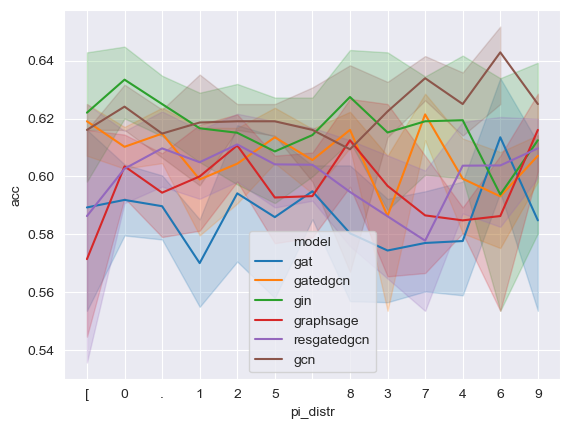

In [321]:
slice = e_df.loc[(e_df['model.num_layers'] == 2) & (e_df['optim.weight_decay'] == 0)]
better_plot(slice, "model.hidden_dim", err_style="band")

In [ ]:
# # slice = expanded_df.loc[(expanded_df['dataset'] == 'aids') & (expanded_df['model'] == 'gin') & (expanded_df['model.num_layers'] == 2) & (expanded_df['optim.weight_decay'] == 0)]
# # slice = expanded_df.loc[(expanded_df['dataset'] == 'aids') & (expanded_df['model'] == 'gat') & (expanded_df['model.num_layers'] == 2) & (expanded_df['optim.weight_decay'] == 0)]
# # slice2 = extend_df(slice)
# # slice2 = slice2.dropna(axis=1)
#
# # plt.figure(1, figsize = (len(metrics)//4, 4))
# fig, axes = plt.subplots(len(metrics)//4, 4, figsize=(40, 20))
#
# for i, metric in enumerate(metrics):
#     try:
#         sns.lineplot(y = metric,
#                      x = "model.hidden_dim",
#                      data = slice,
#                      hue = 'model',
#                      # err_style="bars",
#                      ax = axes[i]
#                      )
#         axes[i].set_title(metric)
#     except:
#         print(f'error in {metric}')
# plt.show()
# # import matplotlib.dates as mdates
# # ax.xaxis.set_major_locator(mdates.MonthLocator(interval=0))
# # ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

In [266]:


def plot_df(df, index=None):
    """
    Plots line and box for the given datafram

    this method will be used to see the distribution of a specific value accross all turbines

    :param df: dataframe to plot
    """
    # for model in df['model']:
    plt.figure()
    if index is not None:
        df = df.set_index(index).sort_index()
    df_1 = df[['acc_mean', 'acc_std', 'loss_mean', 'loss_std']]
    df_1.plot.bar(subplots=True, layout=(-1, 2))
    df_1.plot.box(subplots=True, layout=(-1, 2))
    metrics = []
    for i in range(7):
        for metric in ['cka', 'cca', 'procrustess']:
            metrics.append(f'{metric}_mean_{i}')
            metrics.append(f'{metric}_std_{i}')
    df_2 = df[metrics].dropna(axis=1)
    df_2.plot.bar(subplots=True, layout=(-1, 4), figsize=(40, 20))
    df_2.plot.box(subplots=True, layout=(-1, 4), figsize=(40, 20))
    plt.show()

In [242]:
# df = proteins_df
# df = enzymes_df
df = aids_df
# df = ptc_fm_df
# slice = df.loc[(df['model.hidden_dim'] == 8) & (df['model.num_layers'] == 2) & (df['optim.weight_decay'] == 0)]

In [243]:
# slice = df.loc[(df['model'] == 'gat') & (df['model.num_layers'] == 2) & (df['optim.weight_decay'] == 0) & (df['model.hidden_dim'] == 8)]
# slice = df.loc[(df['model'] == 'gat') & (df['model.num_layers'] == 2) & (df['optim.weight_decay'] == 0)]
slice = df.loc[(df['model.num_layers'] == 2) & (df['optim.weight_decay'] == 0)]

In [244]:
slice

,Unnamed: 0,optim.name,optim.learning_rate,optim.weight_decay,cka.use_masks,cka.mode,cka.save_to_disk,seed,datasplit_seed,keep_init_seed_constant,...,cka_6,procrustess_6,model.dropout_p,rsa_cos_0,rsa_cos_1,rsa_cos_2,rsa_cos_3,rsa_cos_4,rsa_cos_5,rsa_cos_6
0,0,Adam,0.01,0.0,['test'],diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,Adam,0.01,0.0,['test'],diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,11,Adam,0.01,0.0,['test'],diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,12,Adam,0.01,0.0,['test'],diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,13,Adam,0.01,0.0,['test'],diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,14,Adam,0.01,0.0,['test'],diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,15,Adam,0.01,0.0,['test'],diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,16,Adam,0.01,0.0,['test'],diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,20,Adam,0.01,0.0,['test'],diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,26,Adam,0.01,0.0,['test'],diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


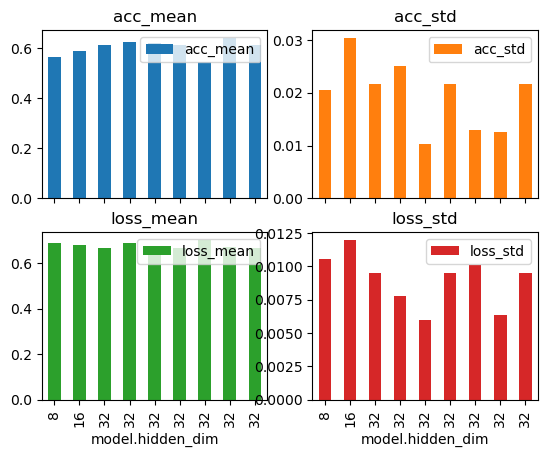

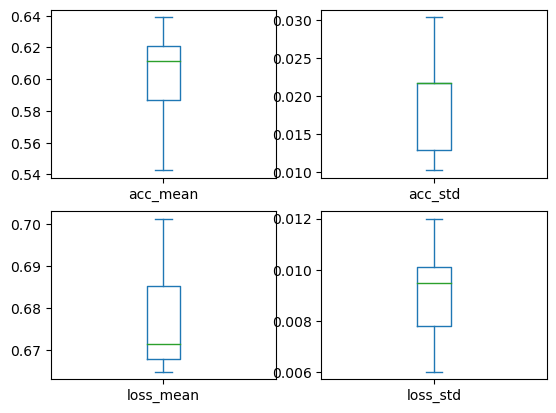

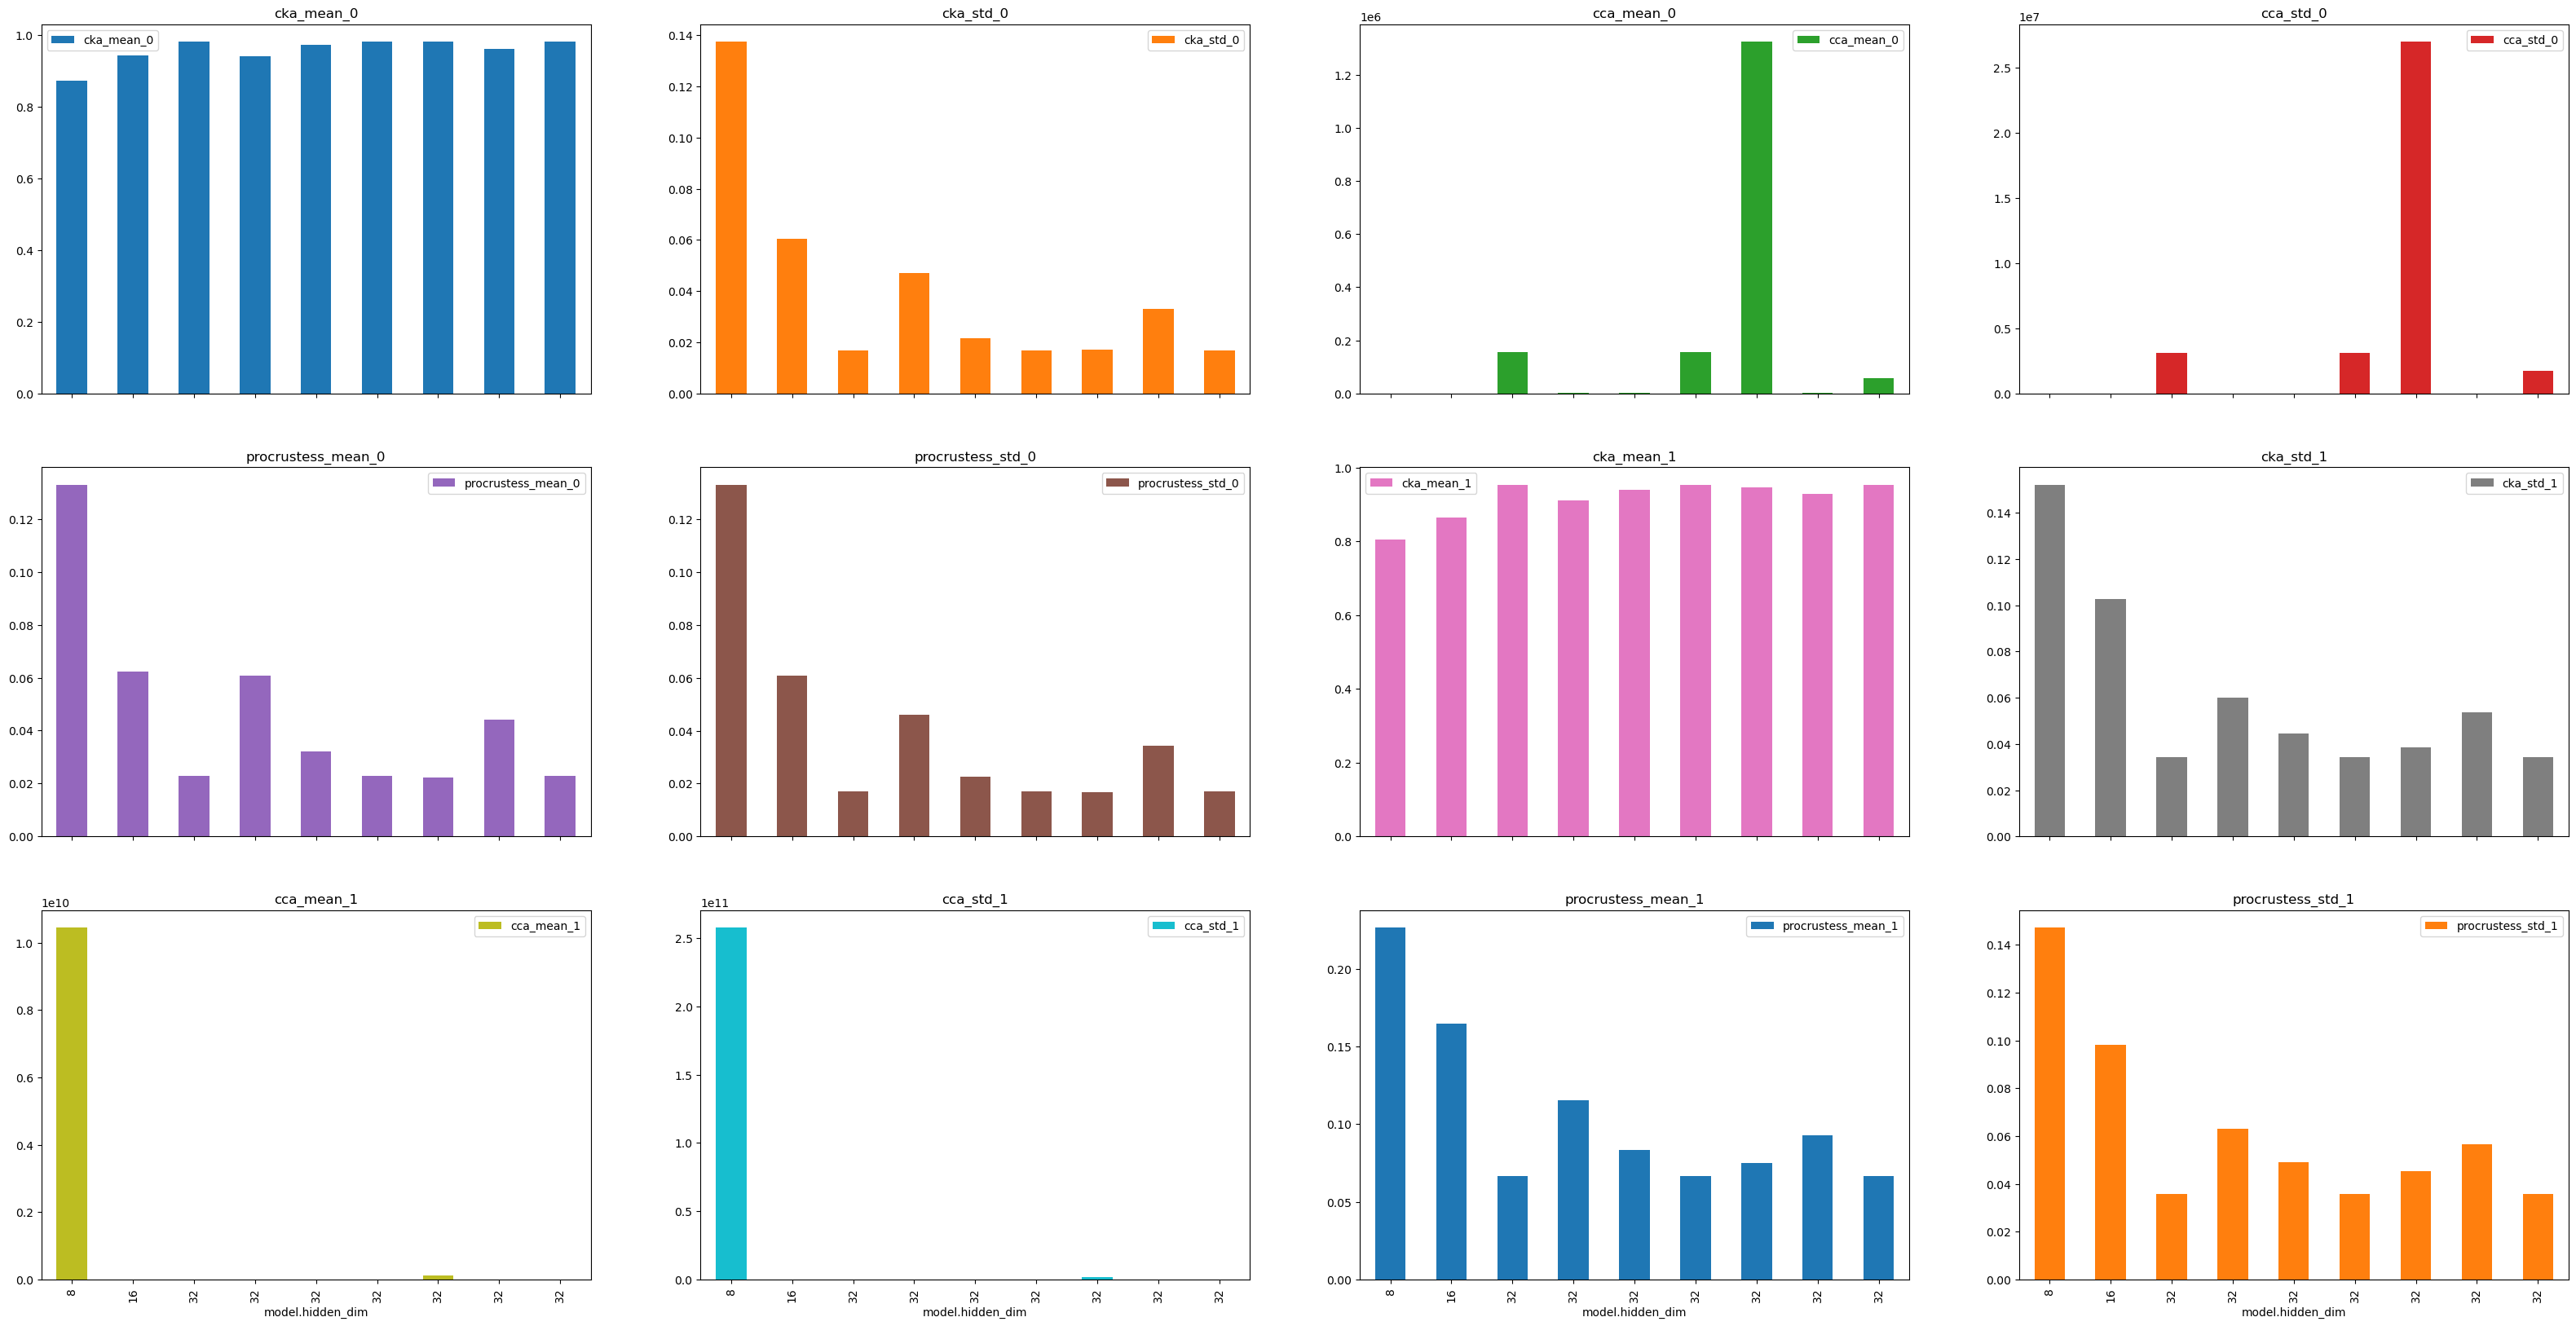

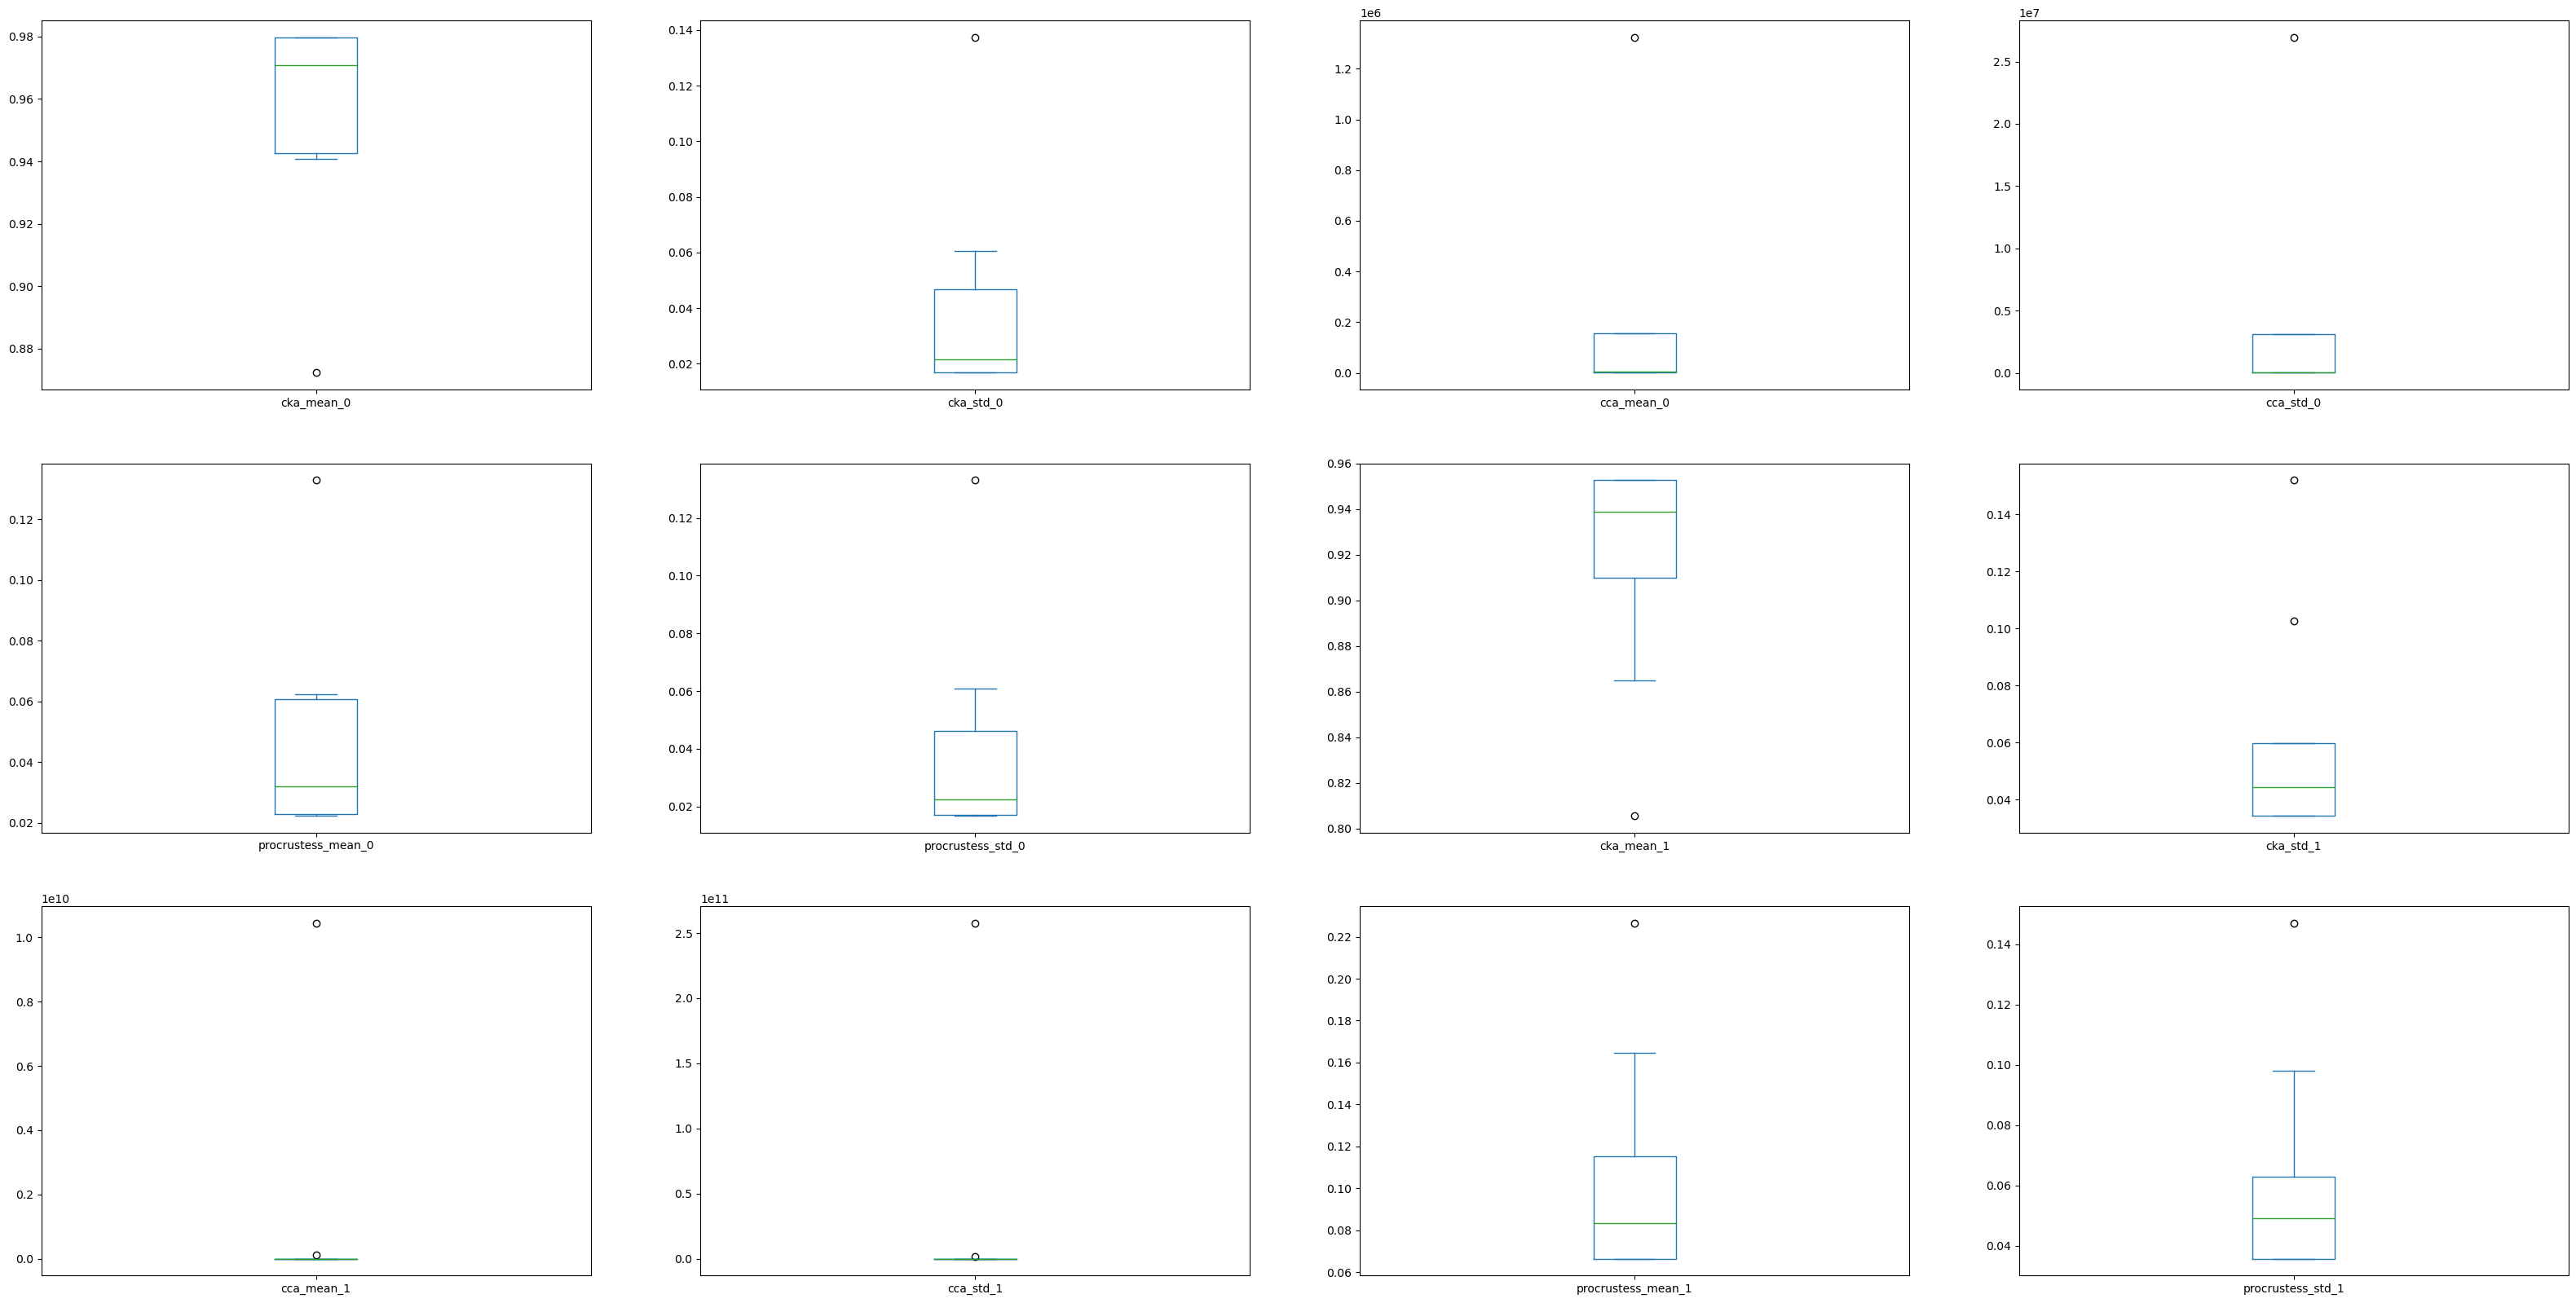

<Figure size 640x480 with 0 Axes>

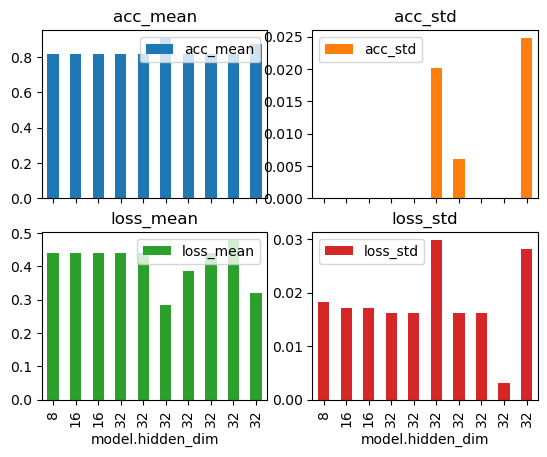

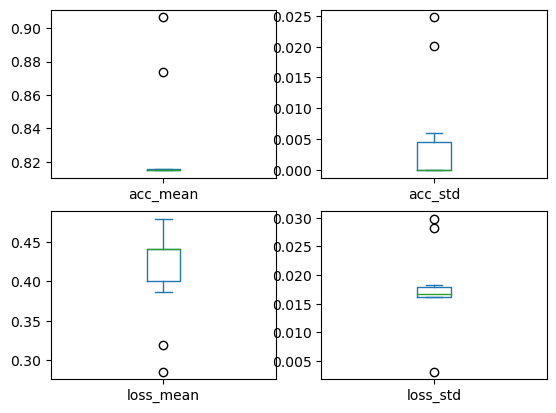

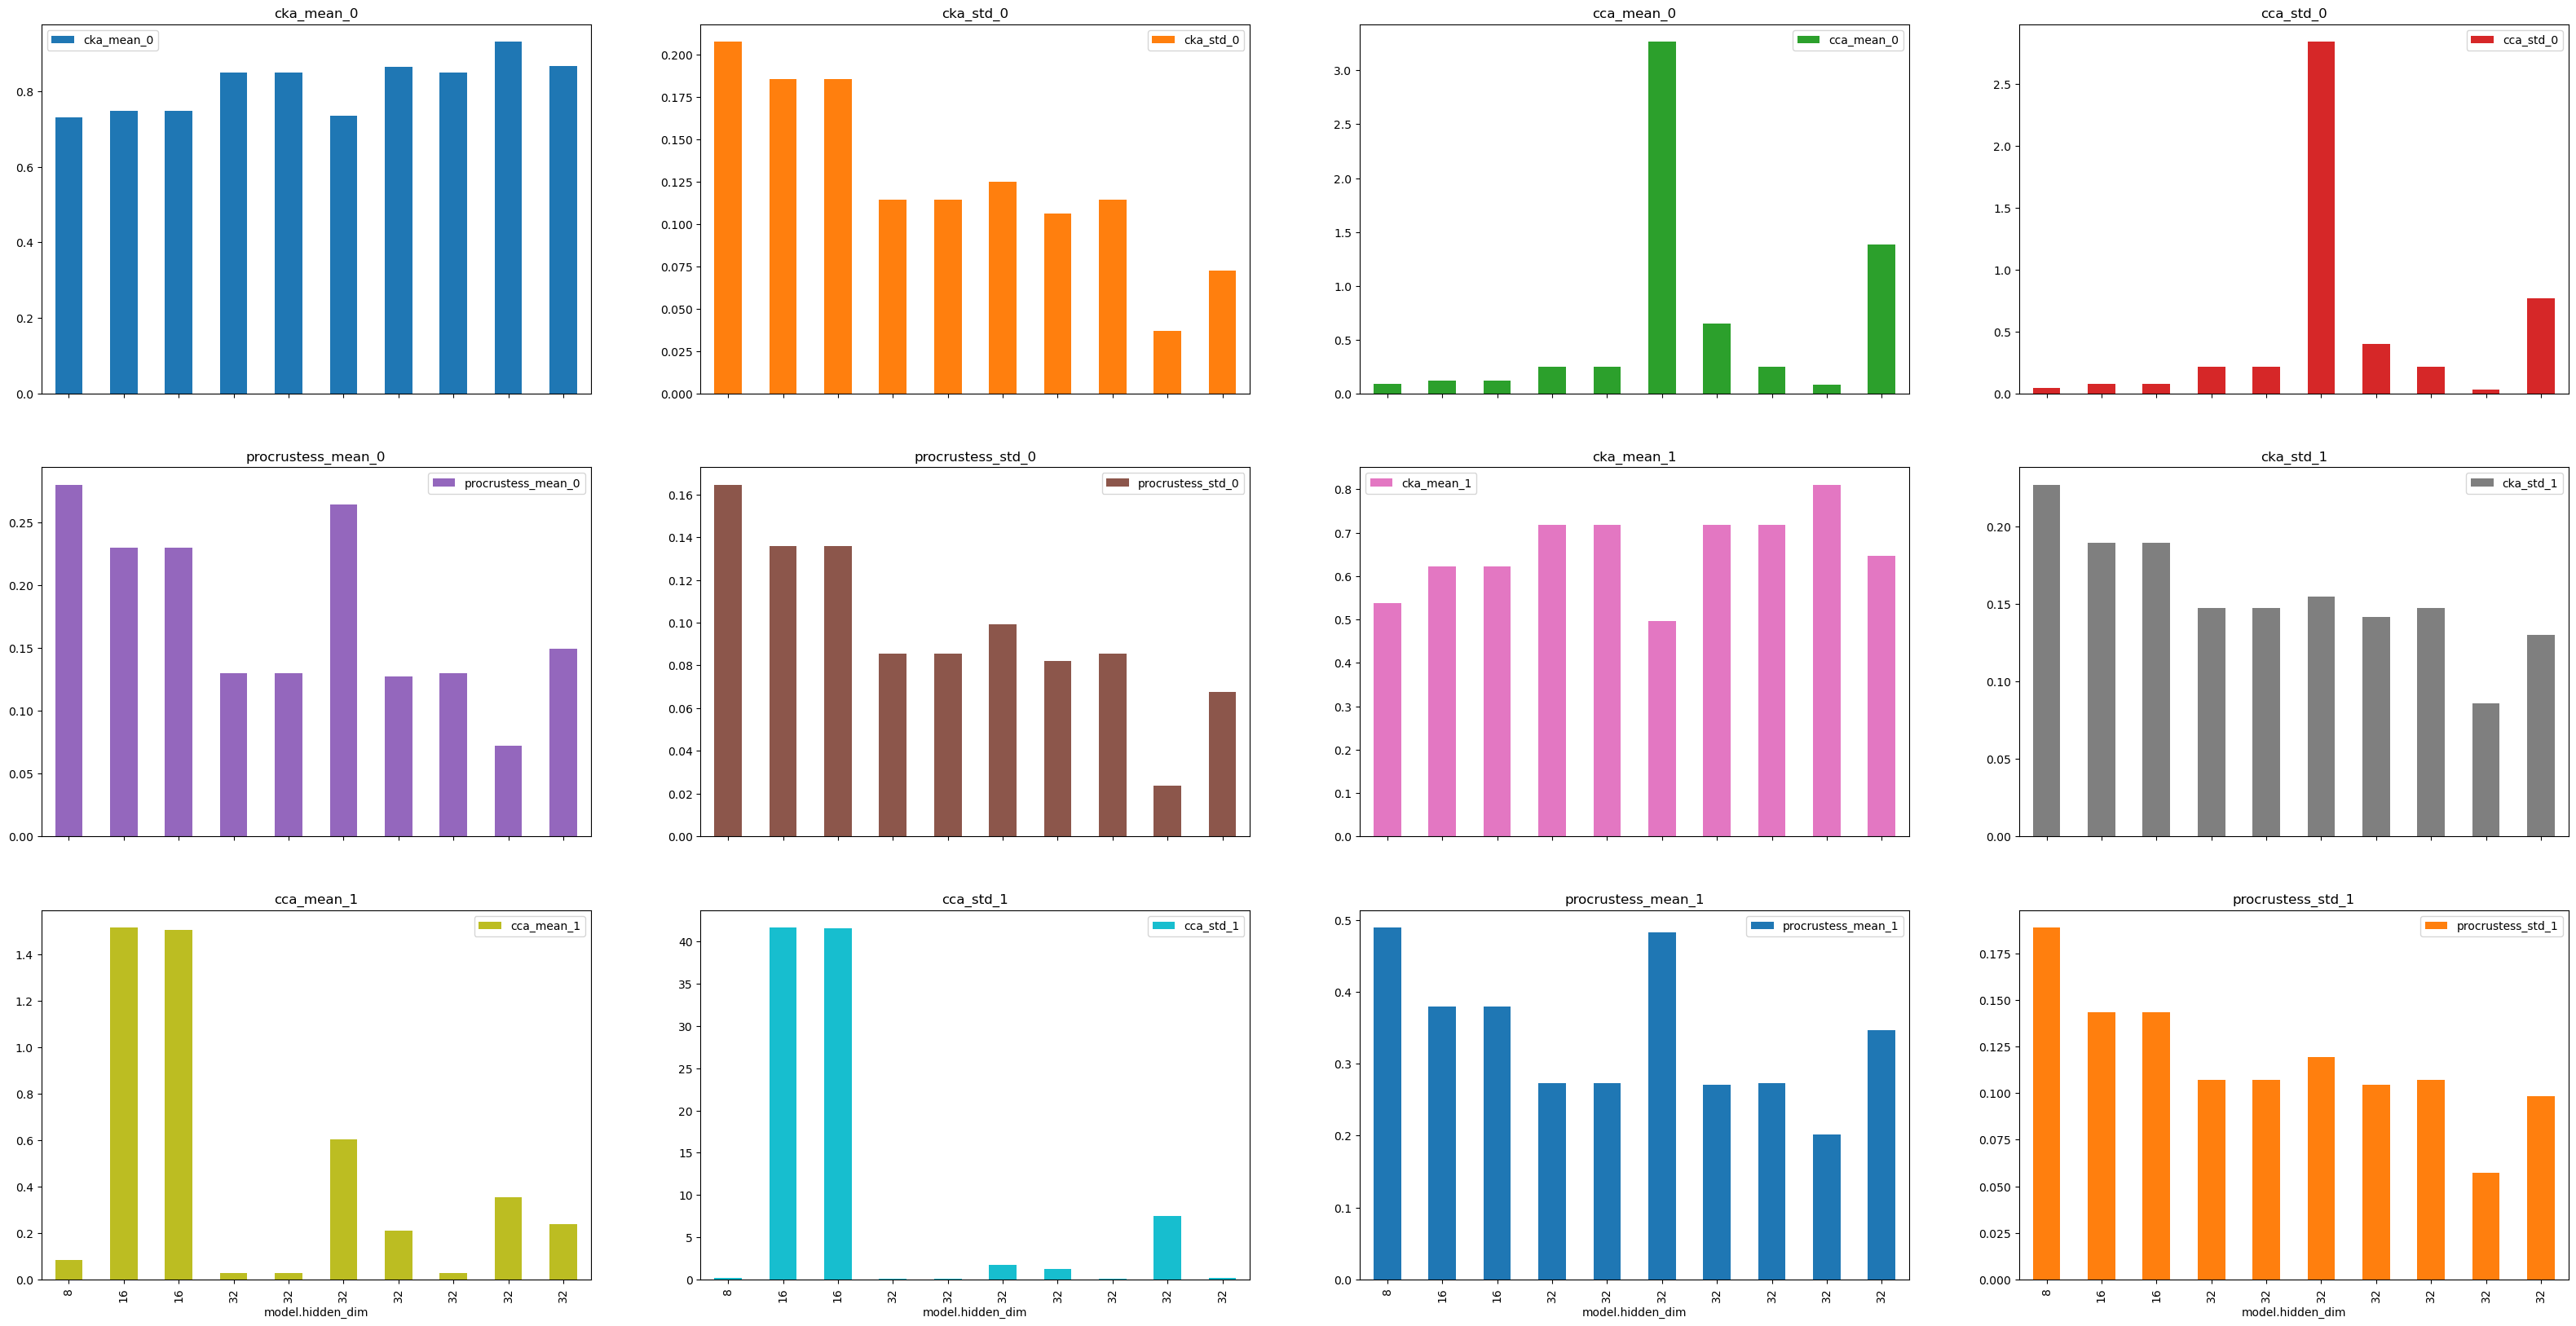

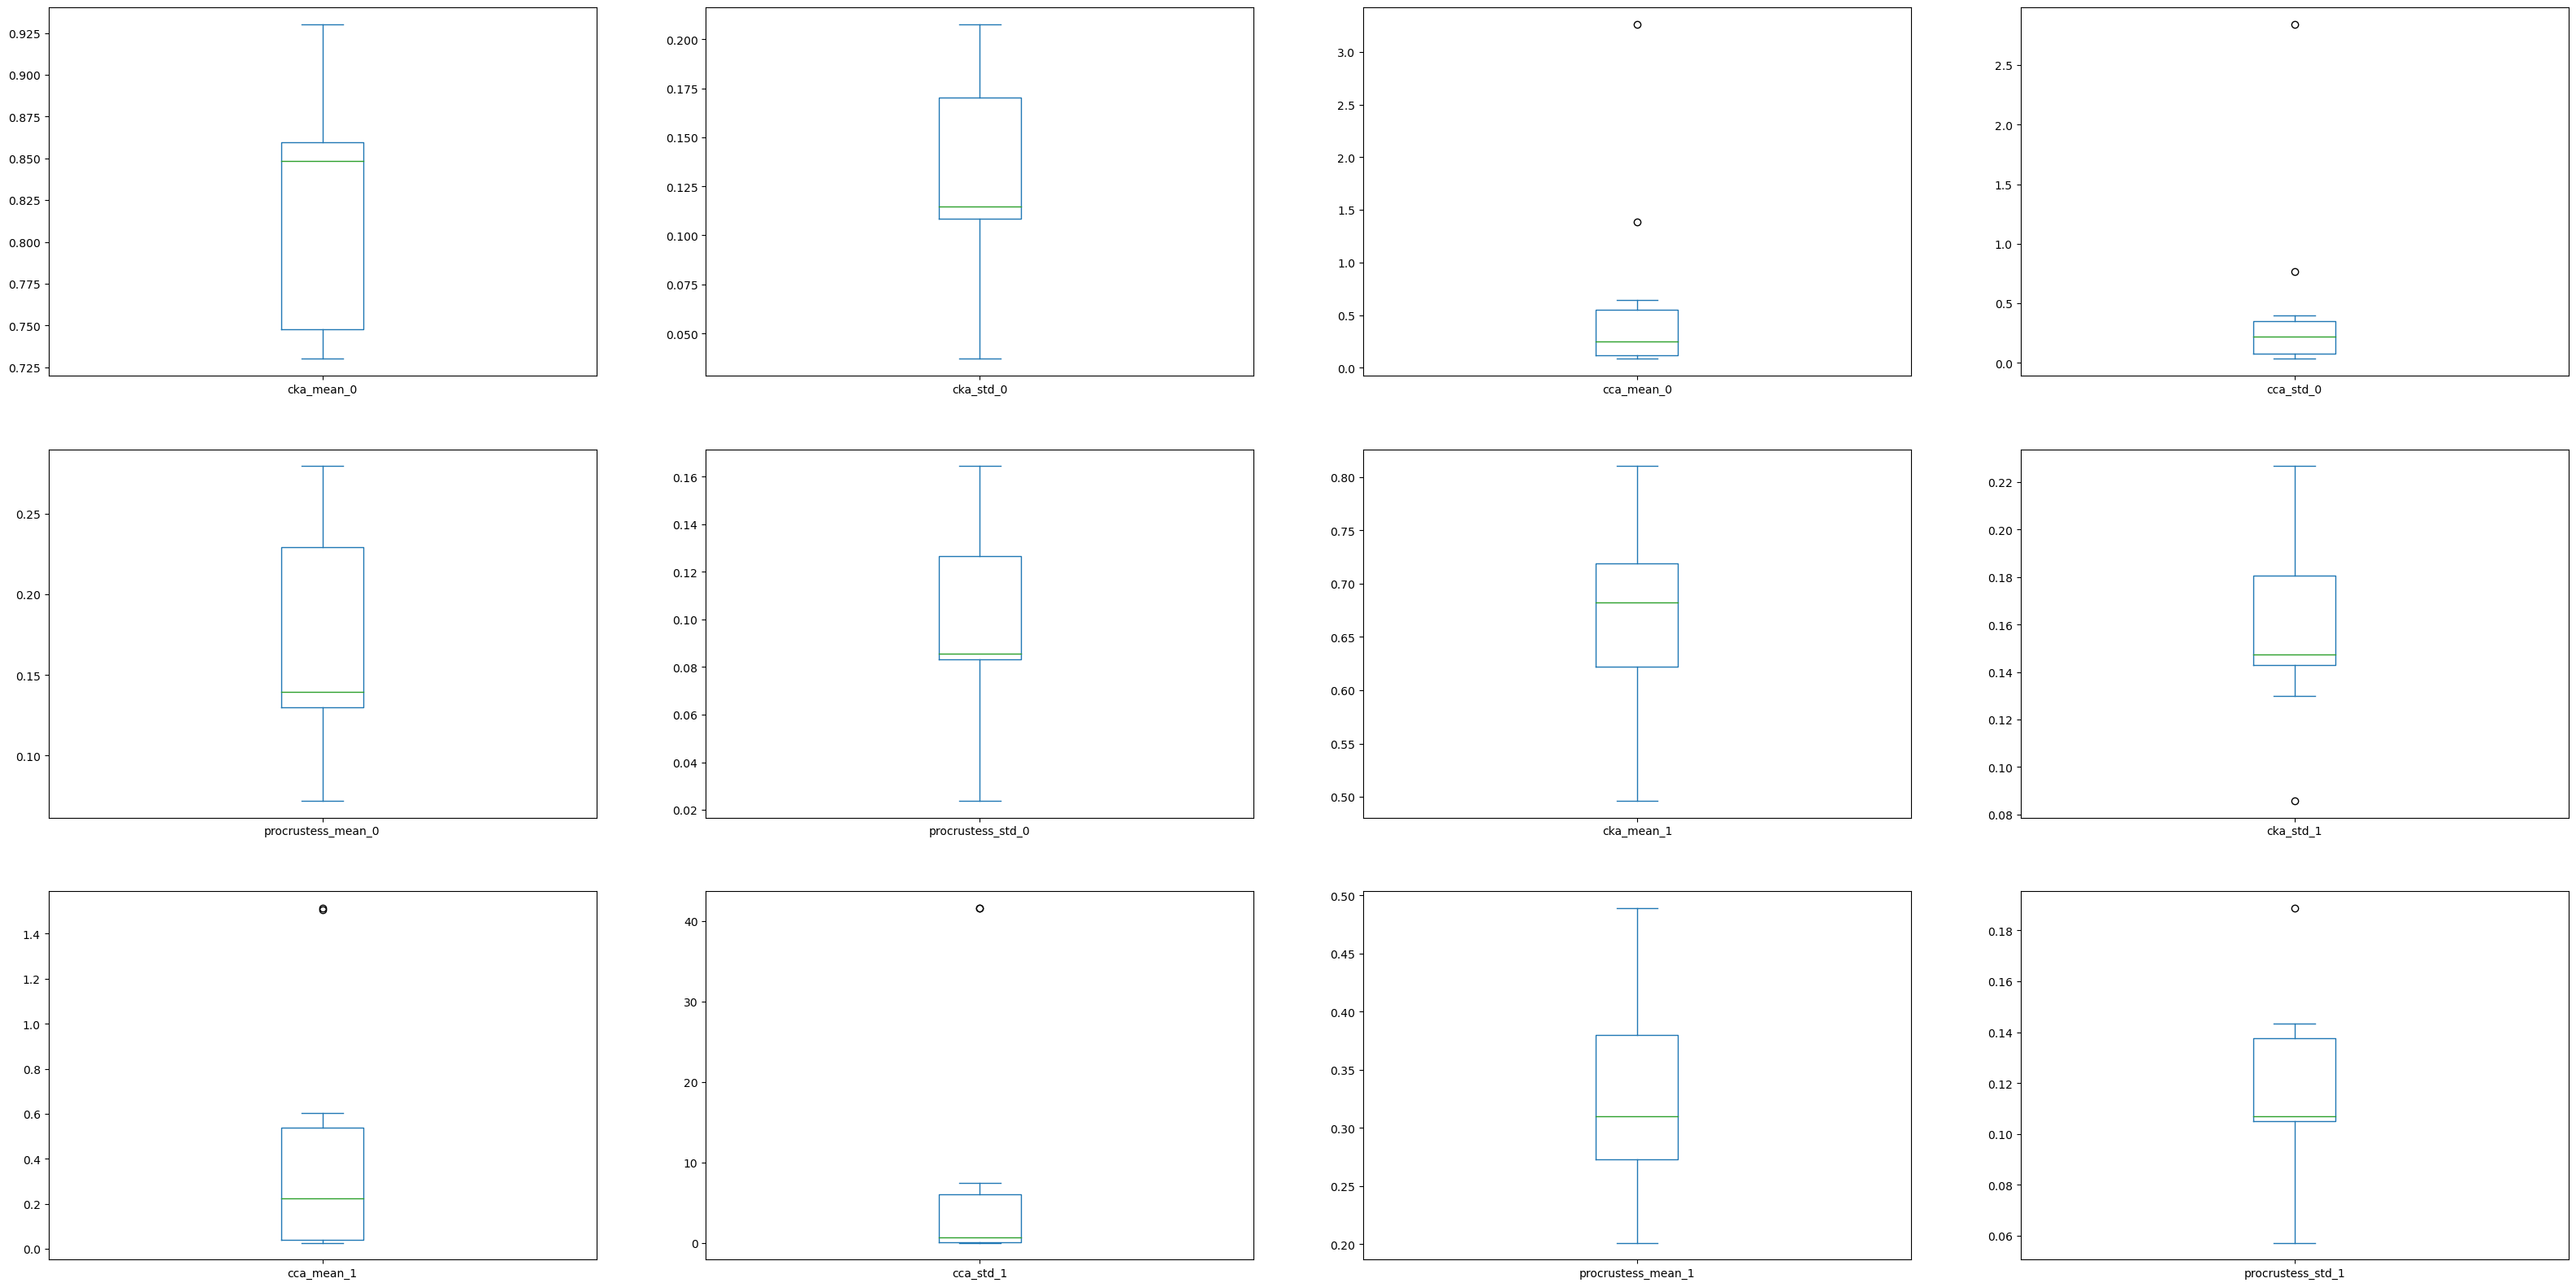

In [269]:
# for model in df.model:
#     print(f'showing results for model: {model}')
#     slice = df.loc[(df['model'] == model) & (df['model.num_layers'] == 2) & (df['optim.weight_decay'] == 0)]
#     plot_df(slice, 'model.hidden_dim')

slice = df.loc[(df['model'] == 'gat') & (df['model.num_layers'] == 2) & (df['optim.weight_decay'] == 0)]
plot_df(slice, 'model.hidden_dim')

<Figure size 640x480 with 0 Axes>

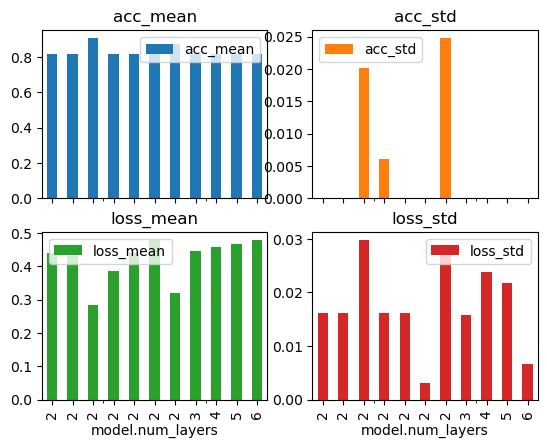

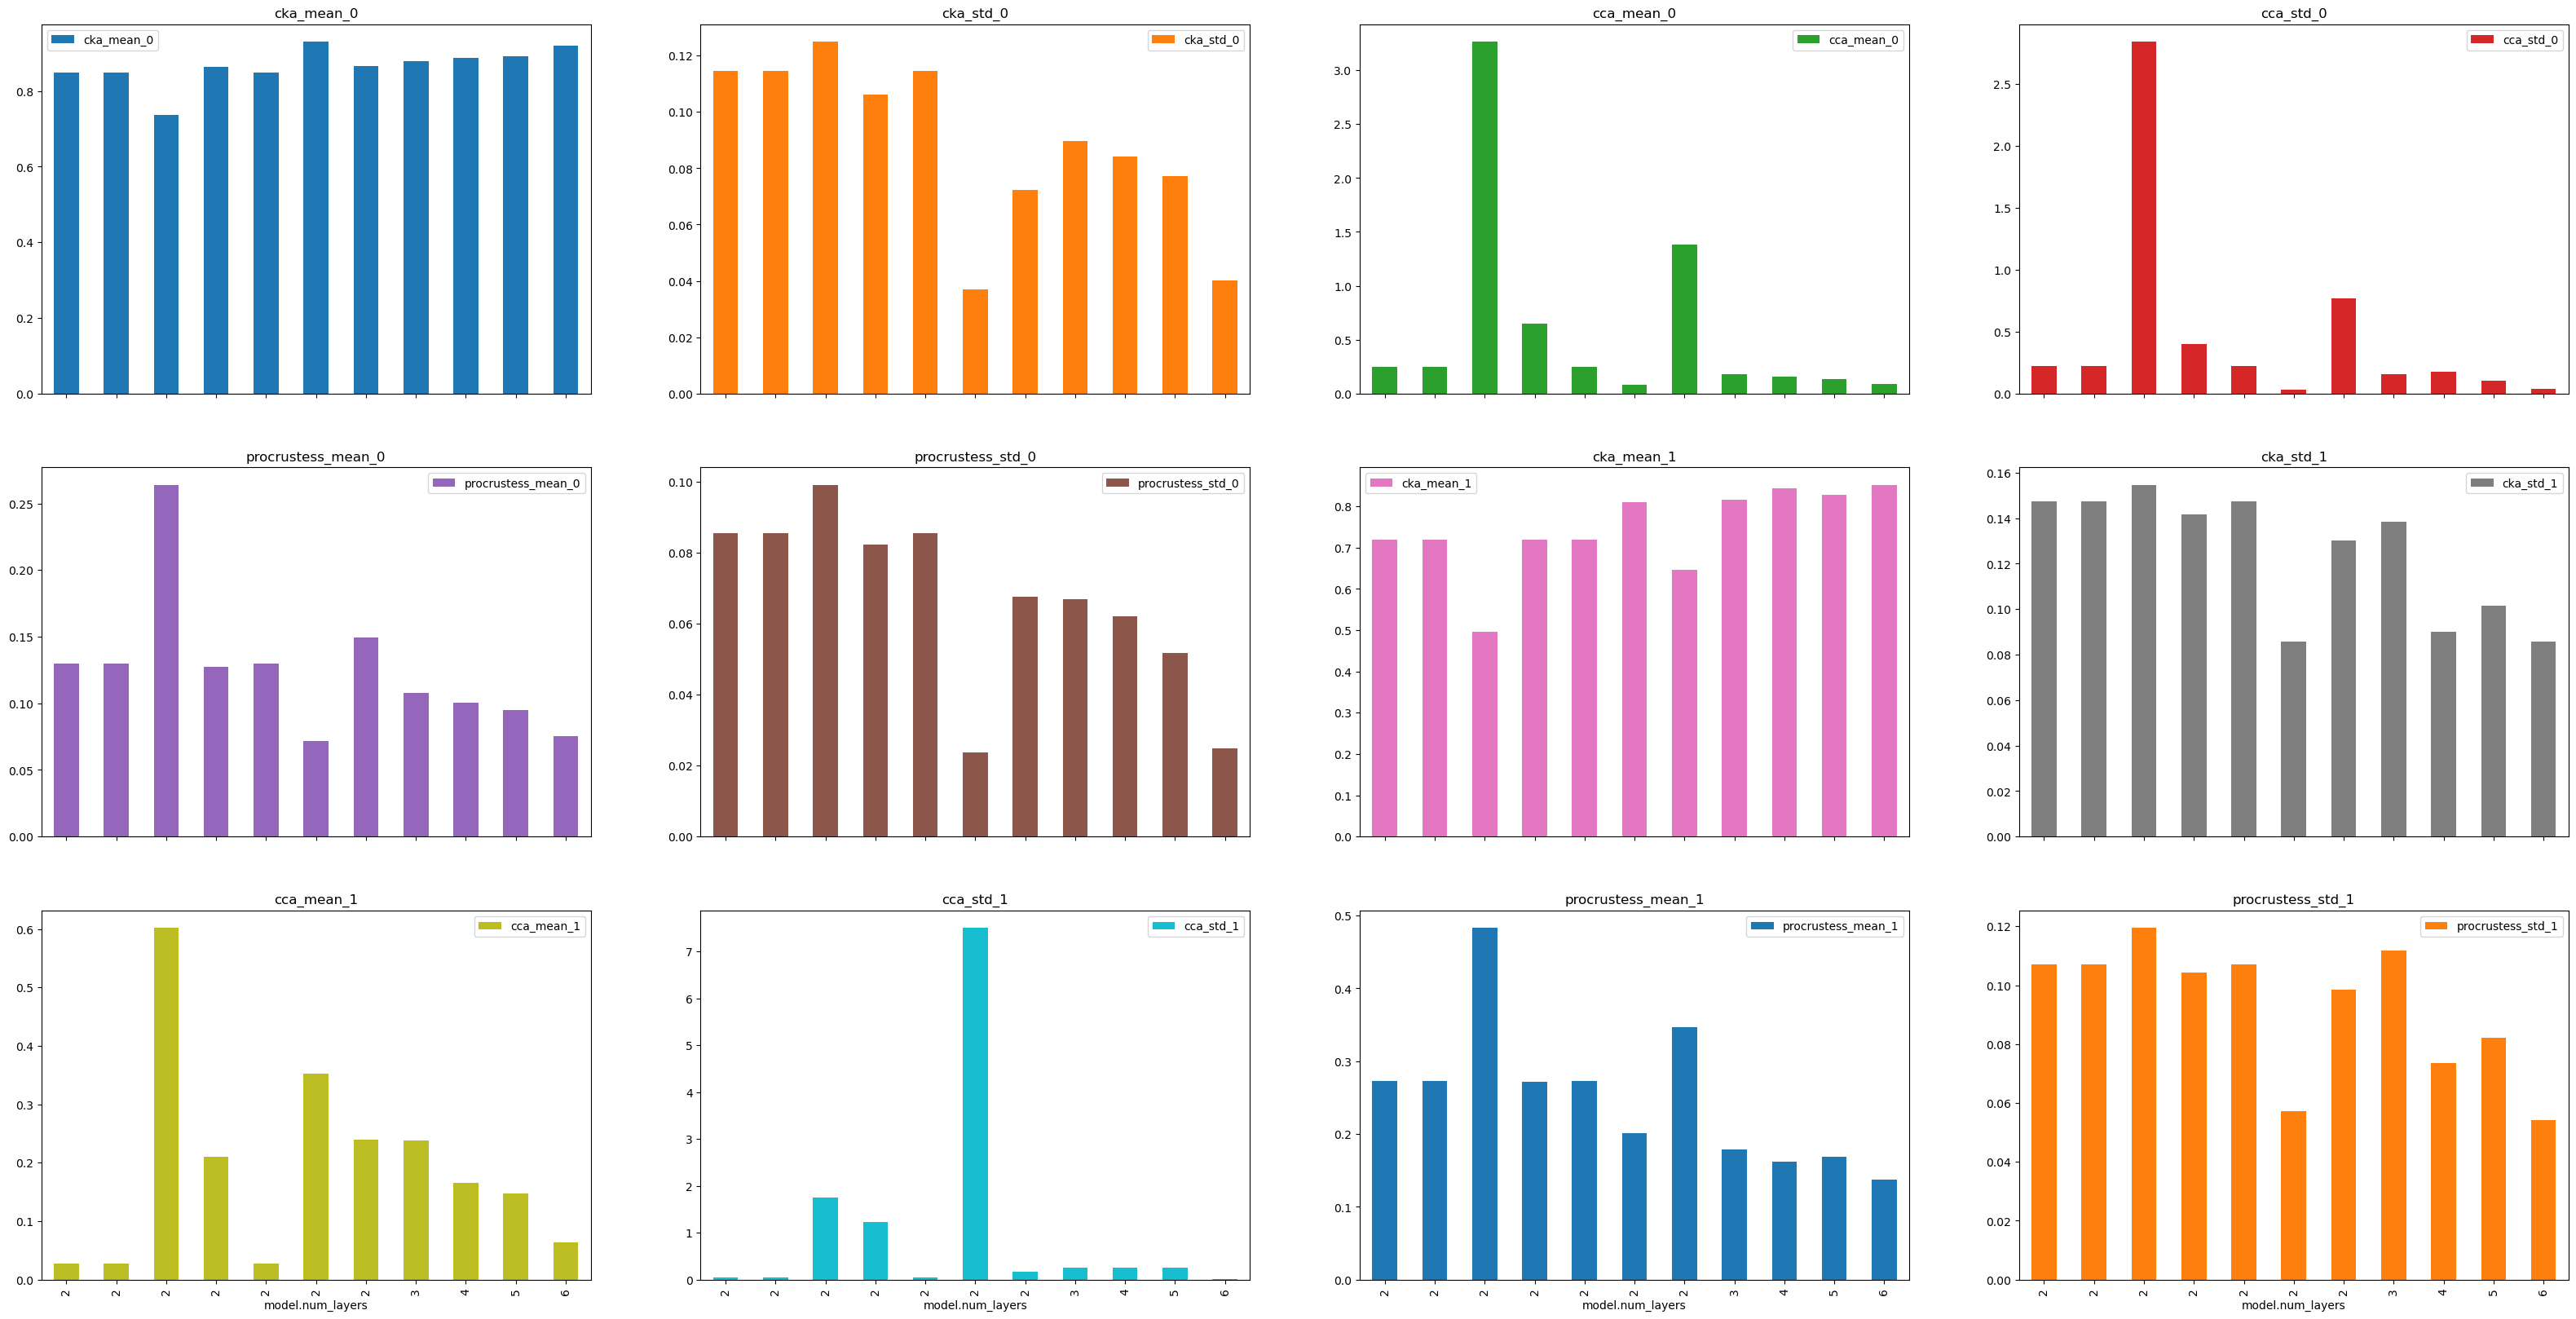

In [250]:
slice = df.loc[(df['model'] == 'gat') & (df['model.hidden_dim'] == 32) & (df['optim.weight_decay'] == 0)]
plot_df(slice, 'model.num_layers')

<Figure size 640x480 with 0 Axes>

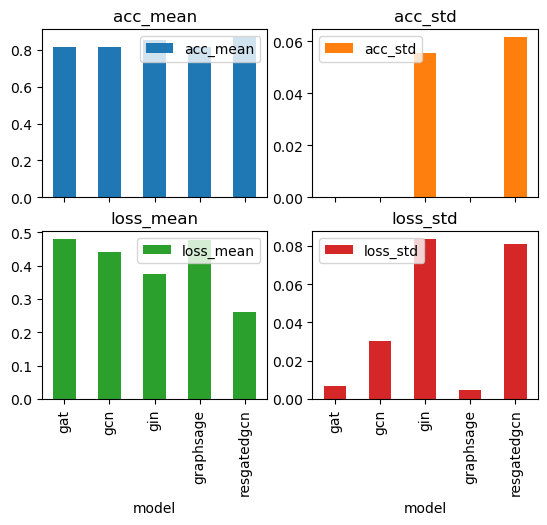

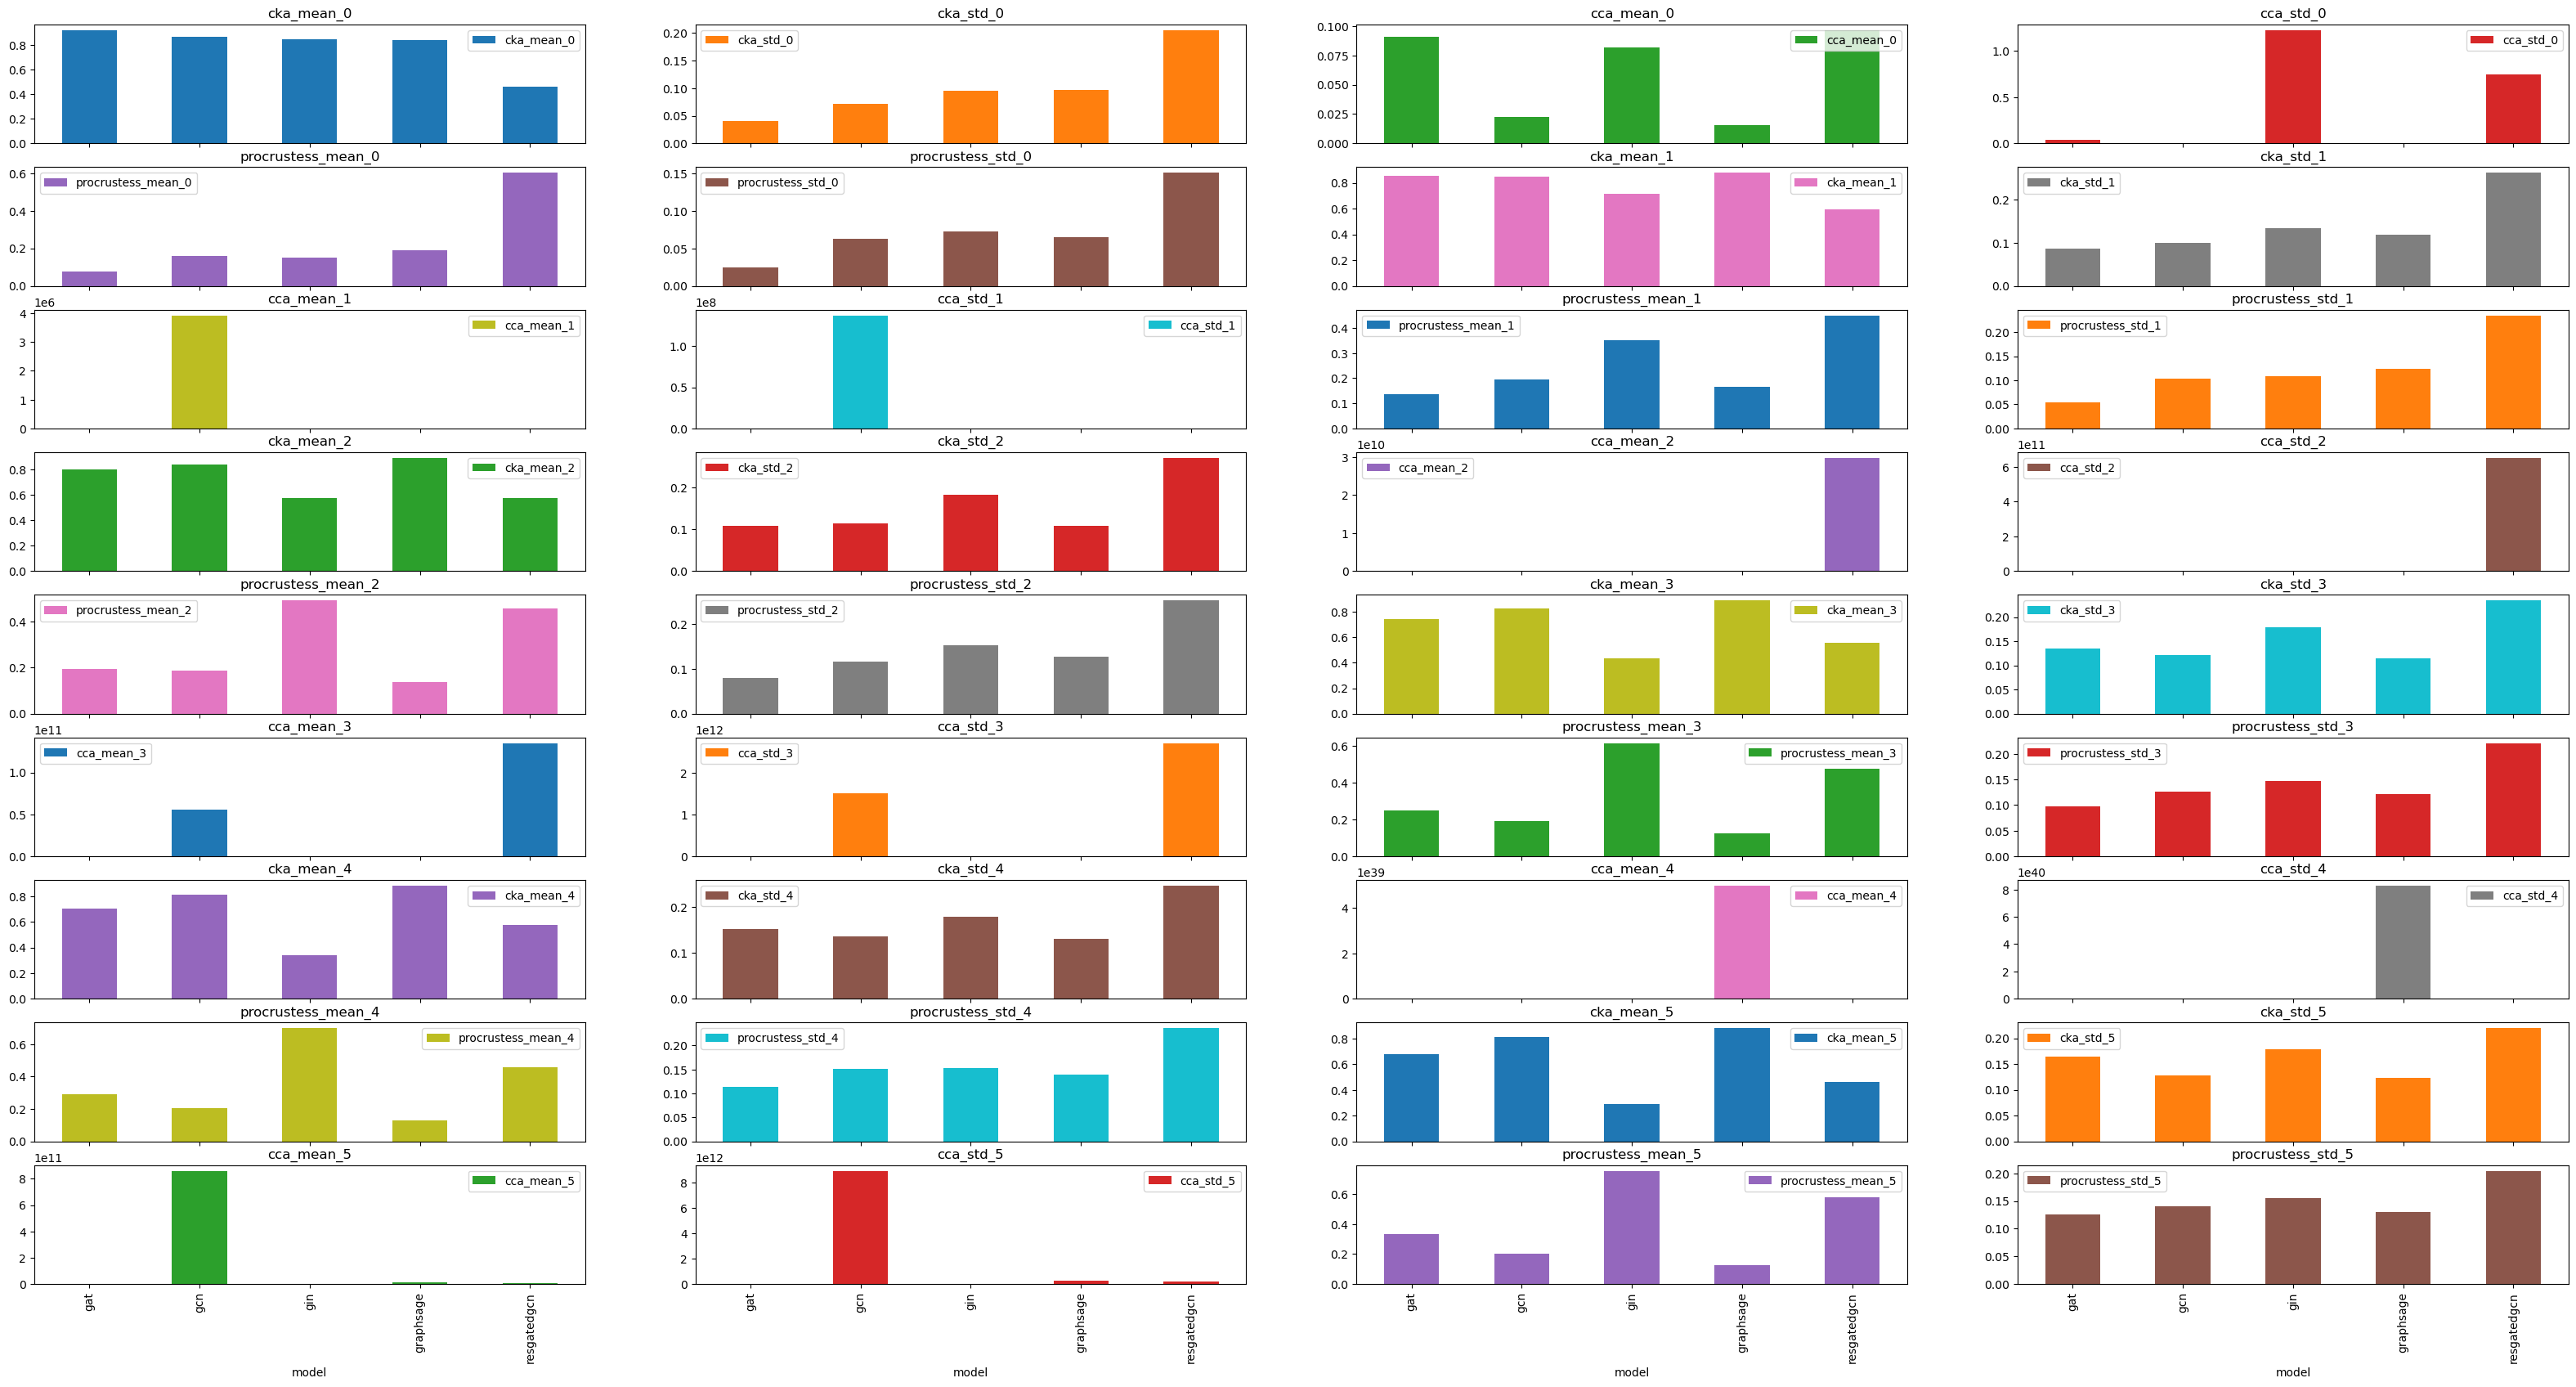

In [251]:
slice = df.loc[(df['model.num_layers'] == 6) & (df['model.hidden_dim'] == 32) & (df['optim.weight_decay'] == 0)]
plot_df(slice, 'model')

<Figure size 640x480 with 0 Axes>

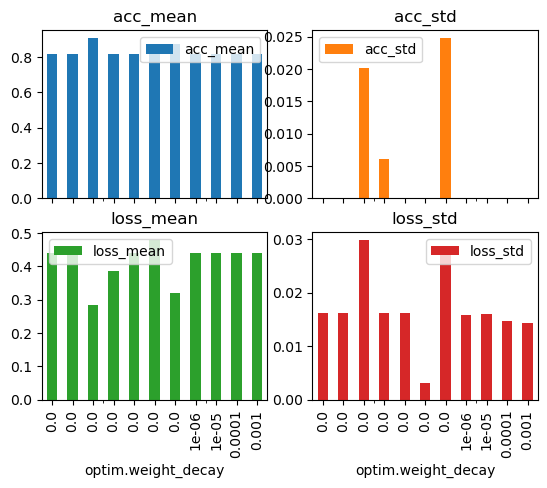

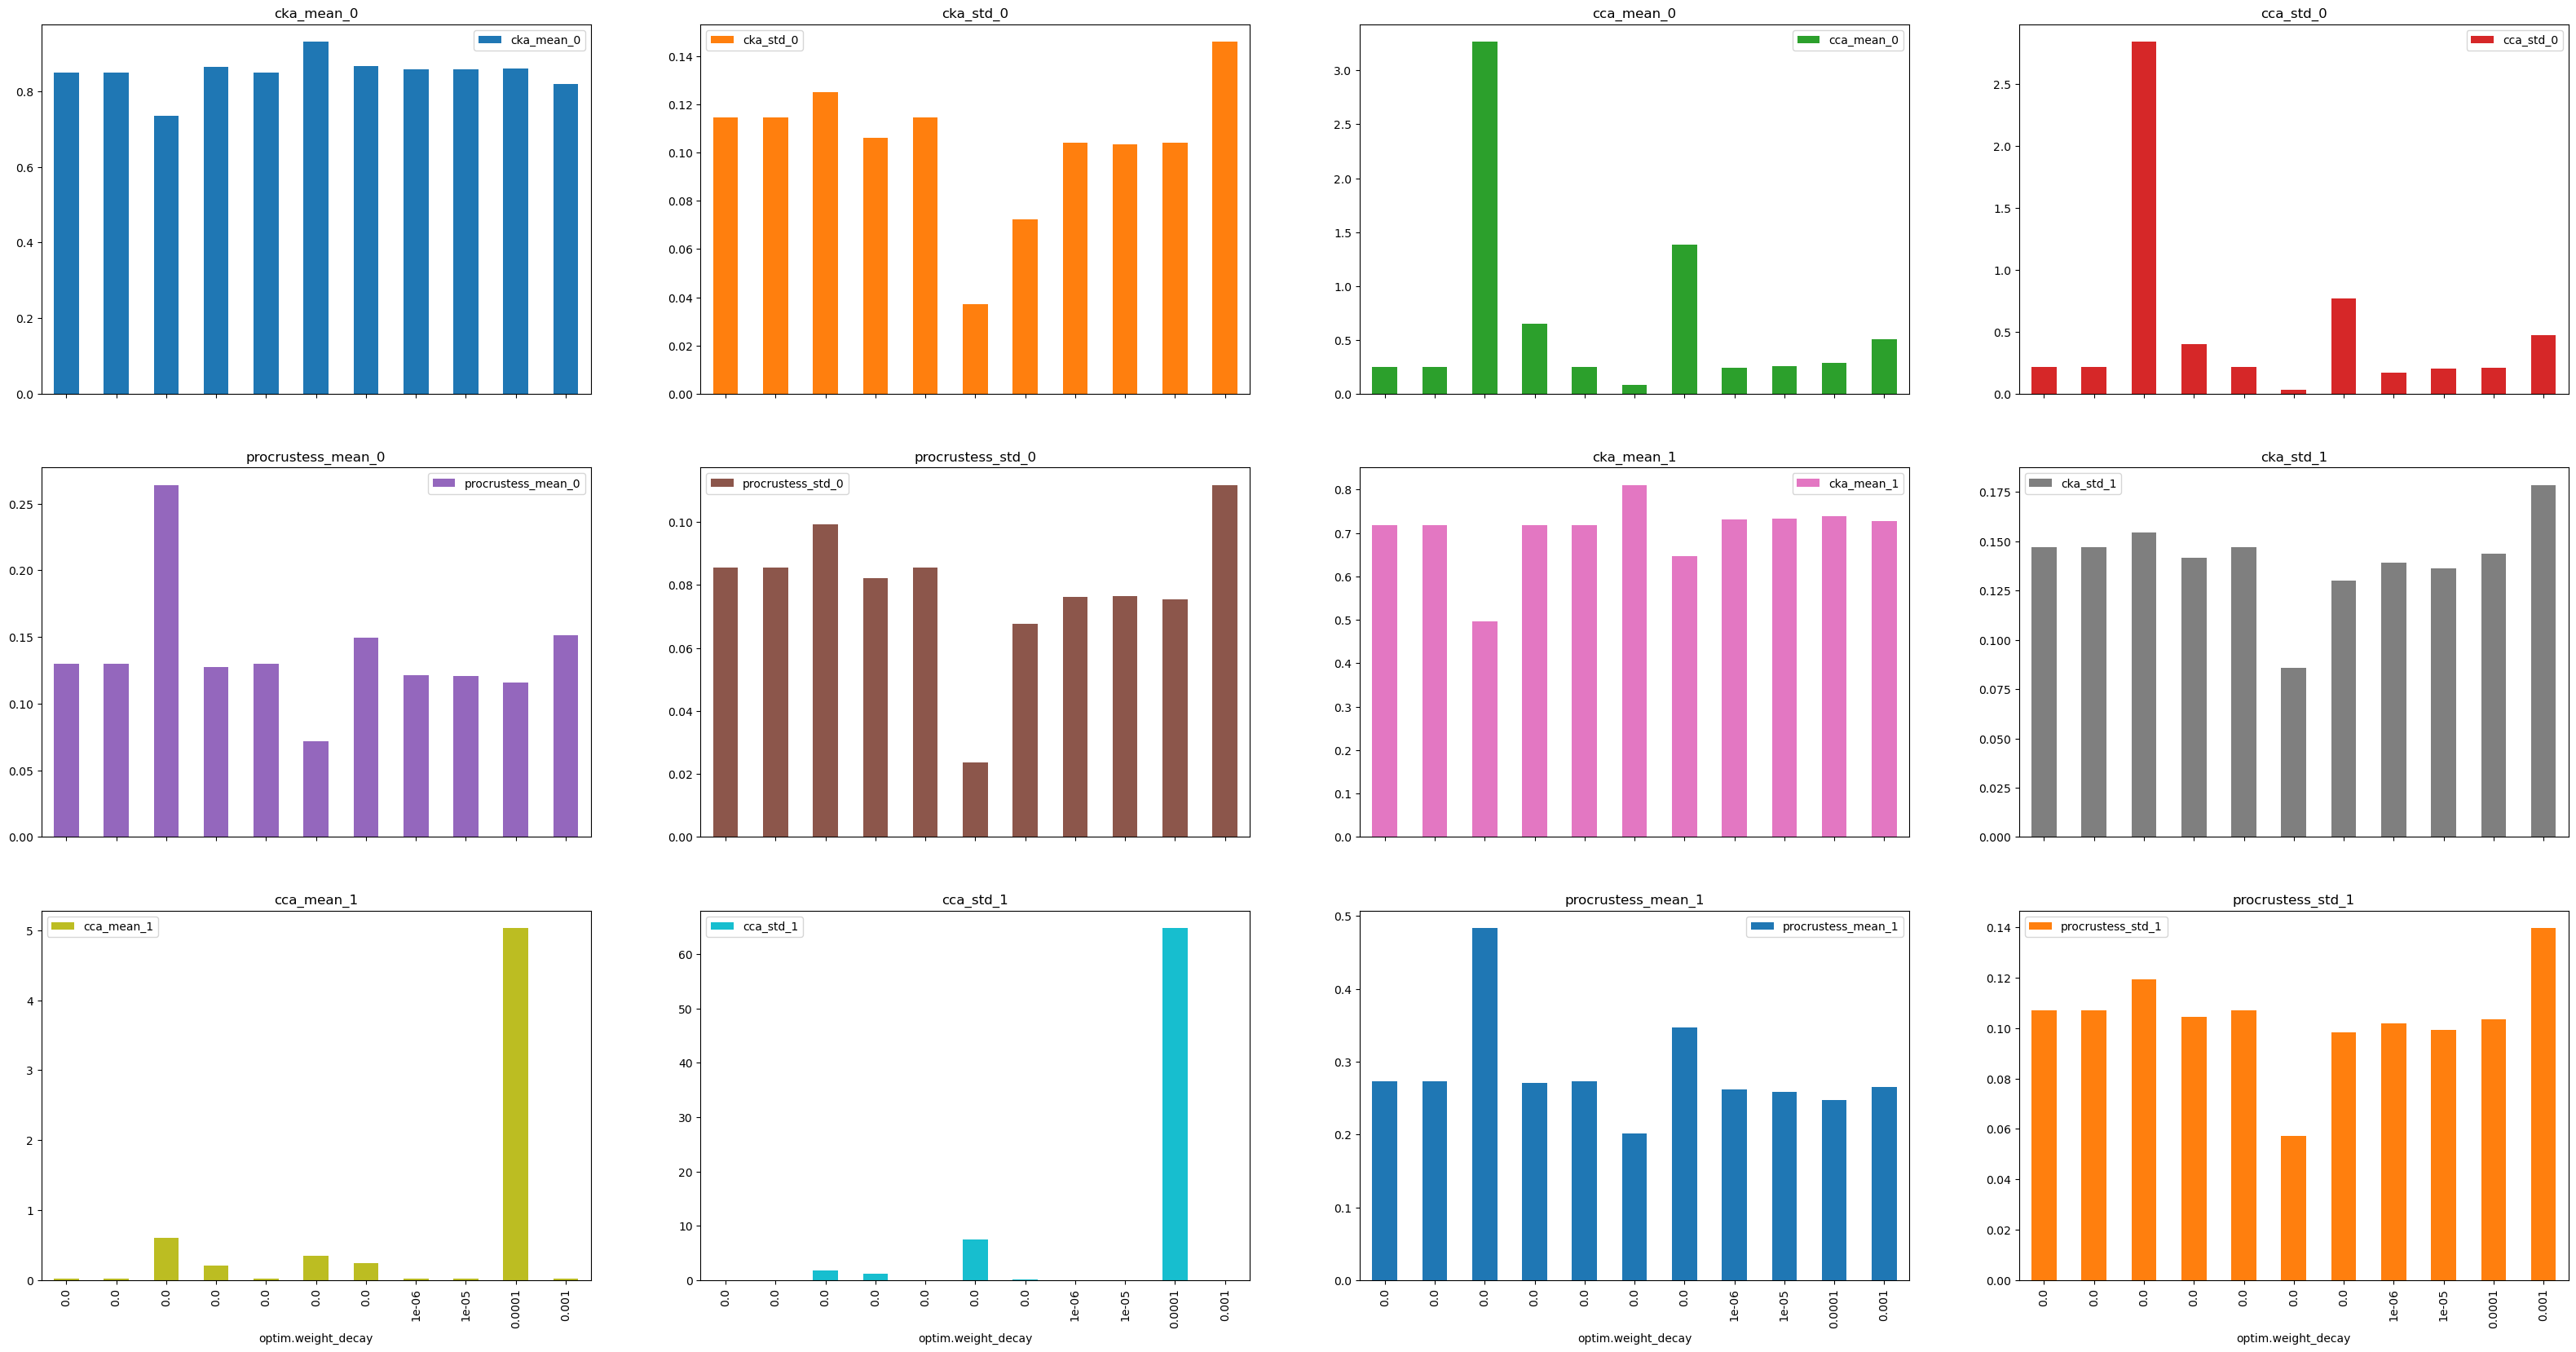

In [252]:
slice = df.loc[(df['model'] == 'gat') & (df['model.num_layers'] == 2) & (df['model.hidden_dim'] == 32)]
plot_df(slice, 'optim.weight_decay')

In [253]:
df = ptc_fm_df

<Figure size 640x480 with 0 Axes>

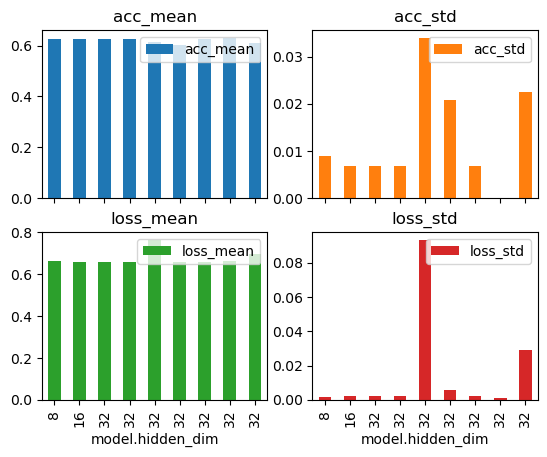

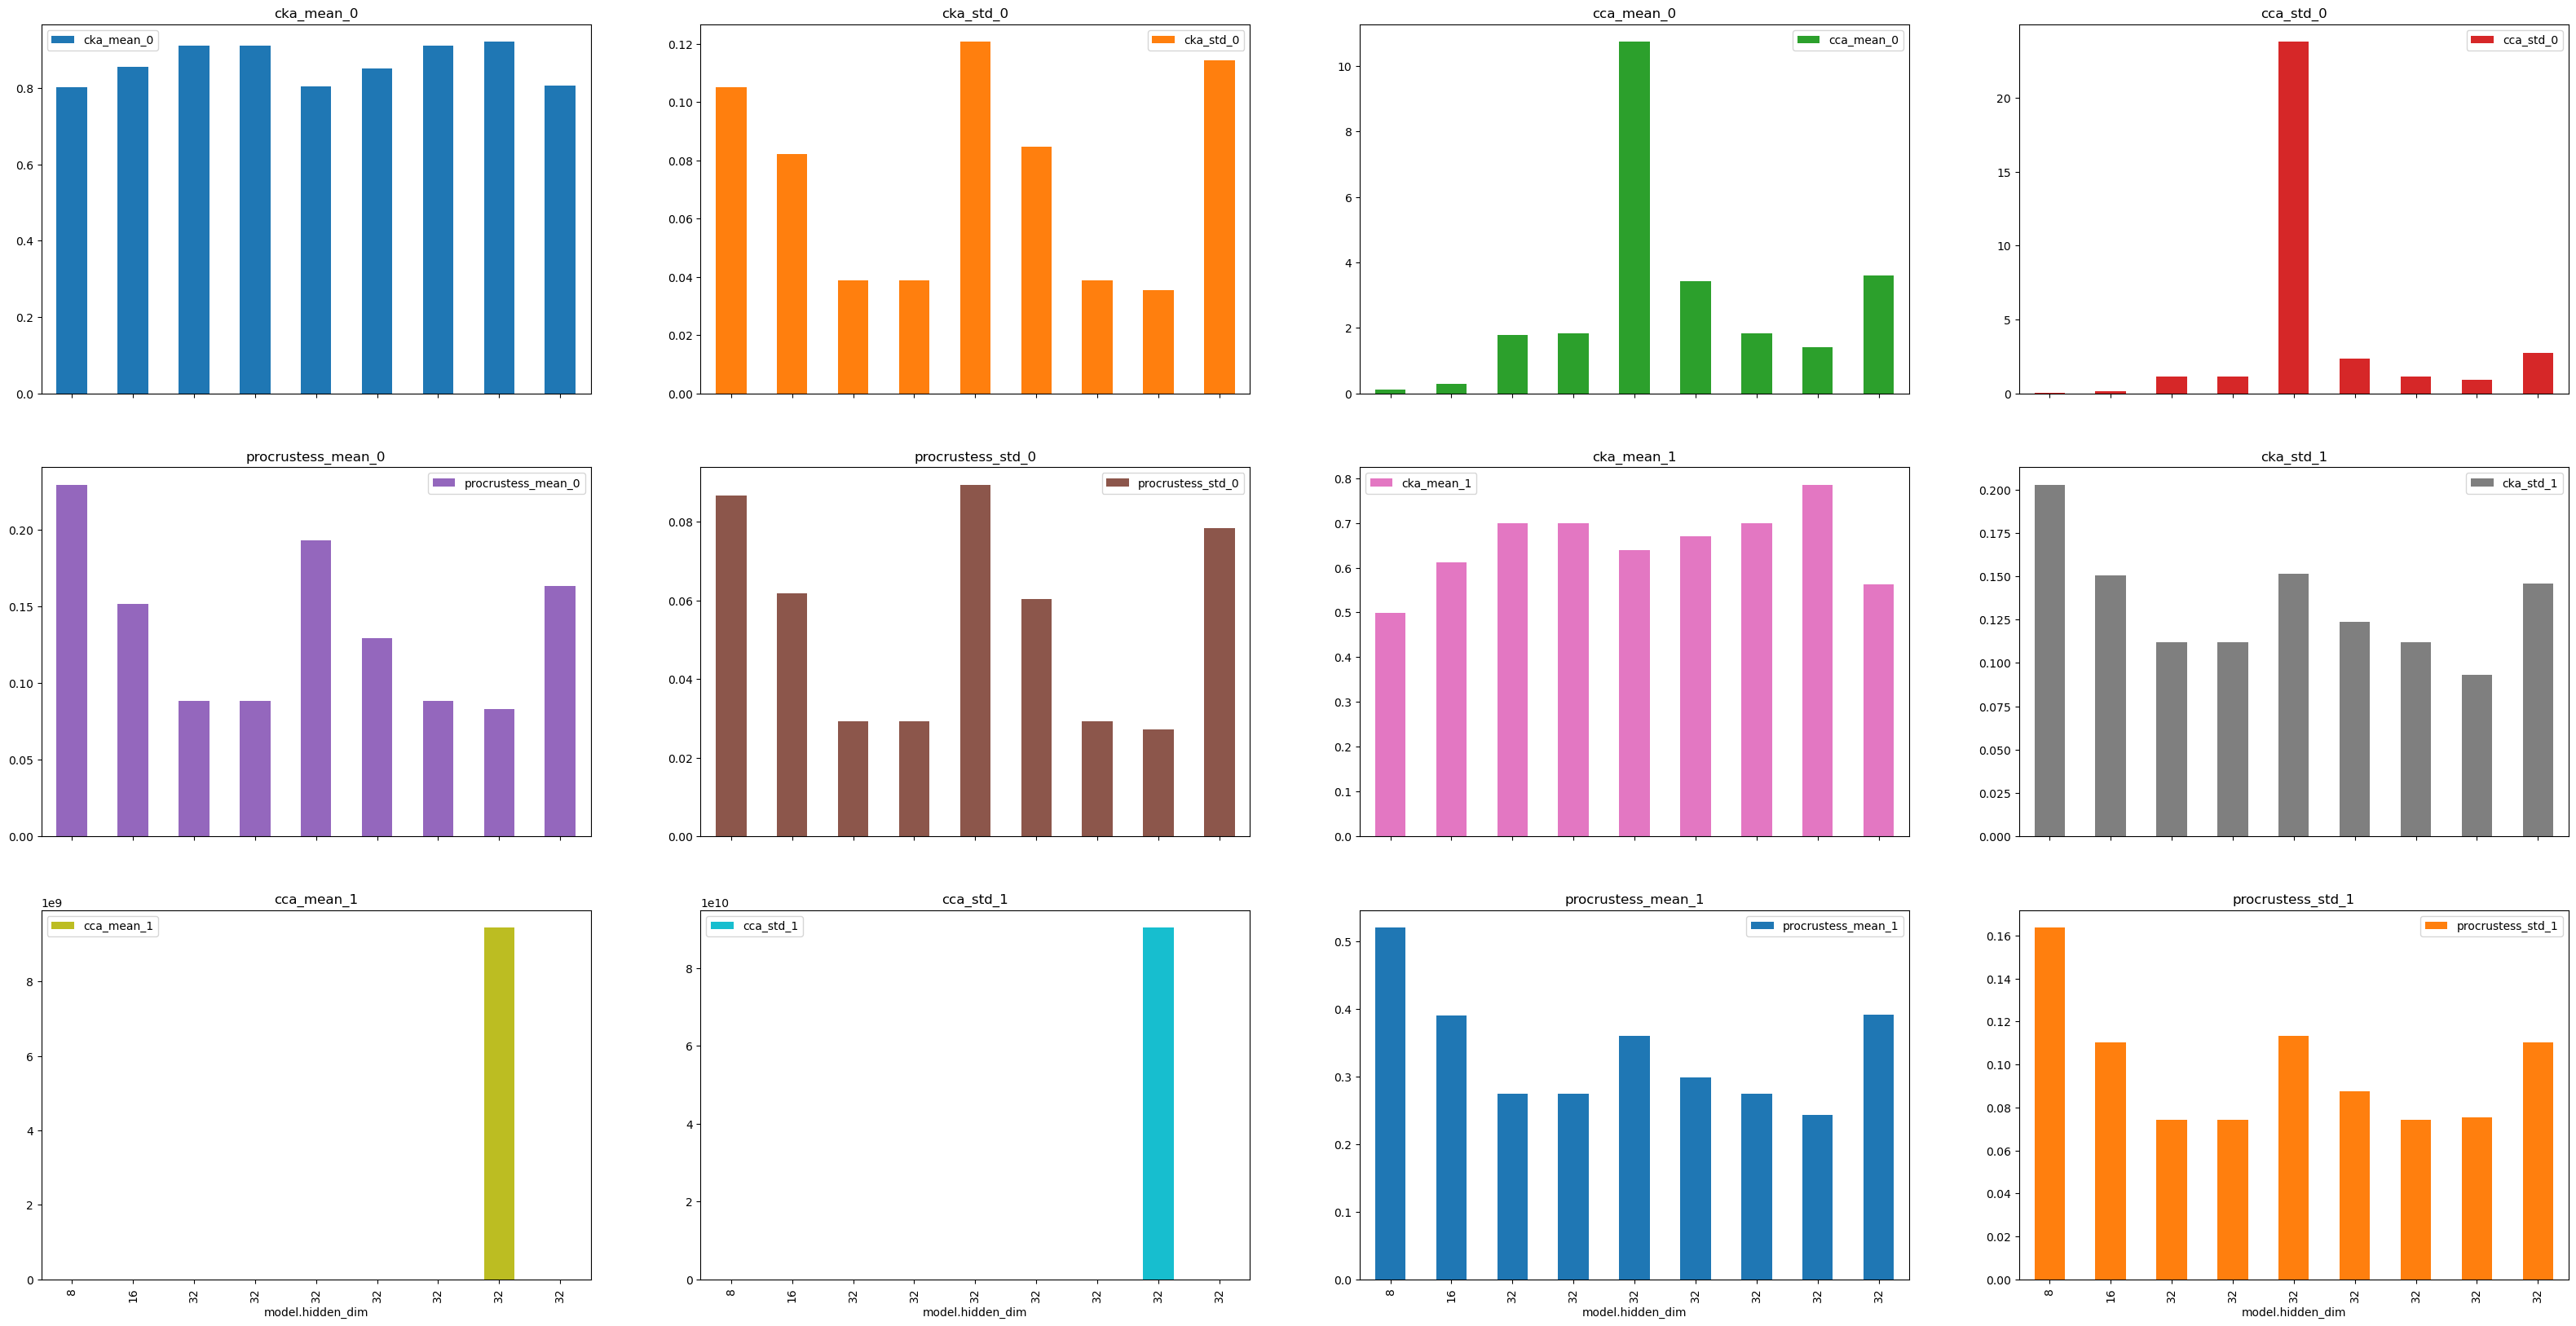

In [254]:
slice = df.loc[(df['model'] == 'gat') & (df['model.num_layers'] == 2) & (df['optim.weight_decay'] == 0)]
plot_df(slice, 'model.hidden_dim')

<Figure size 640x480 with 0 Axes>

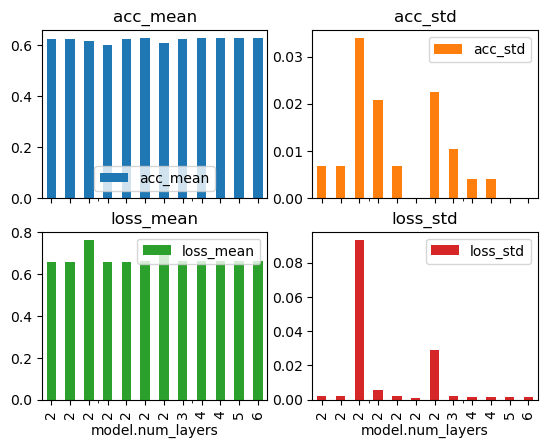

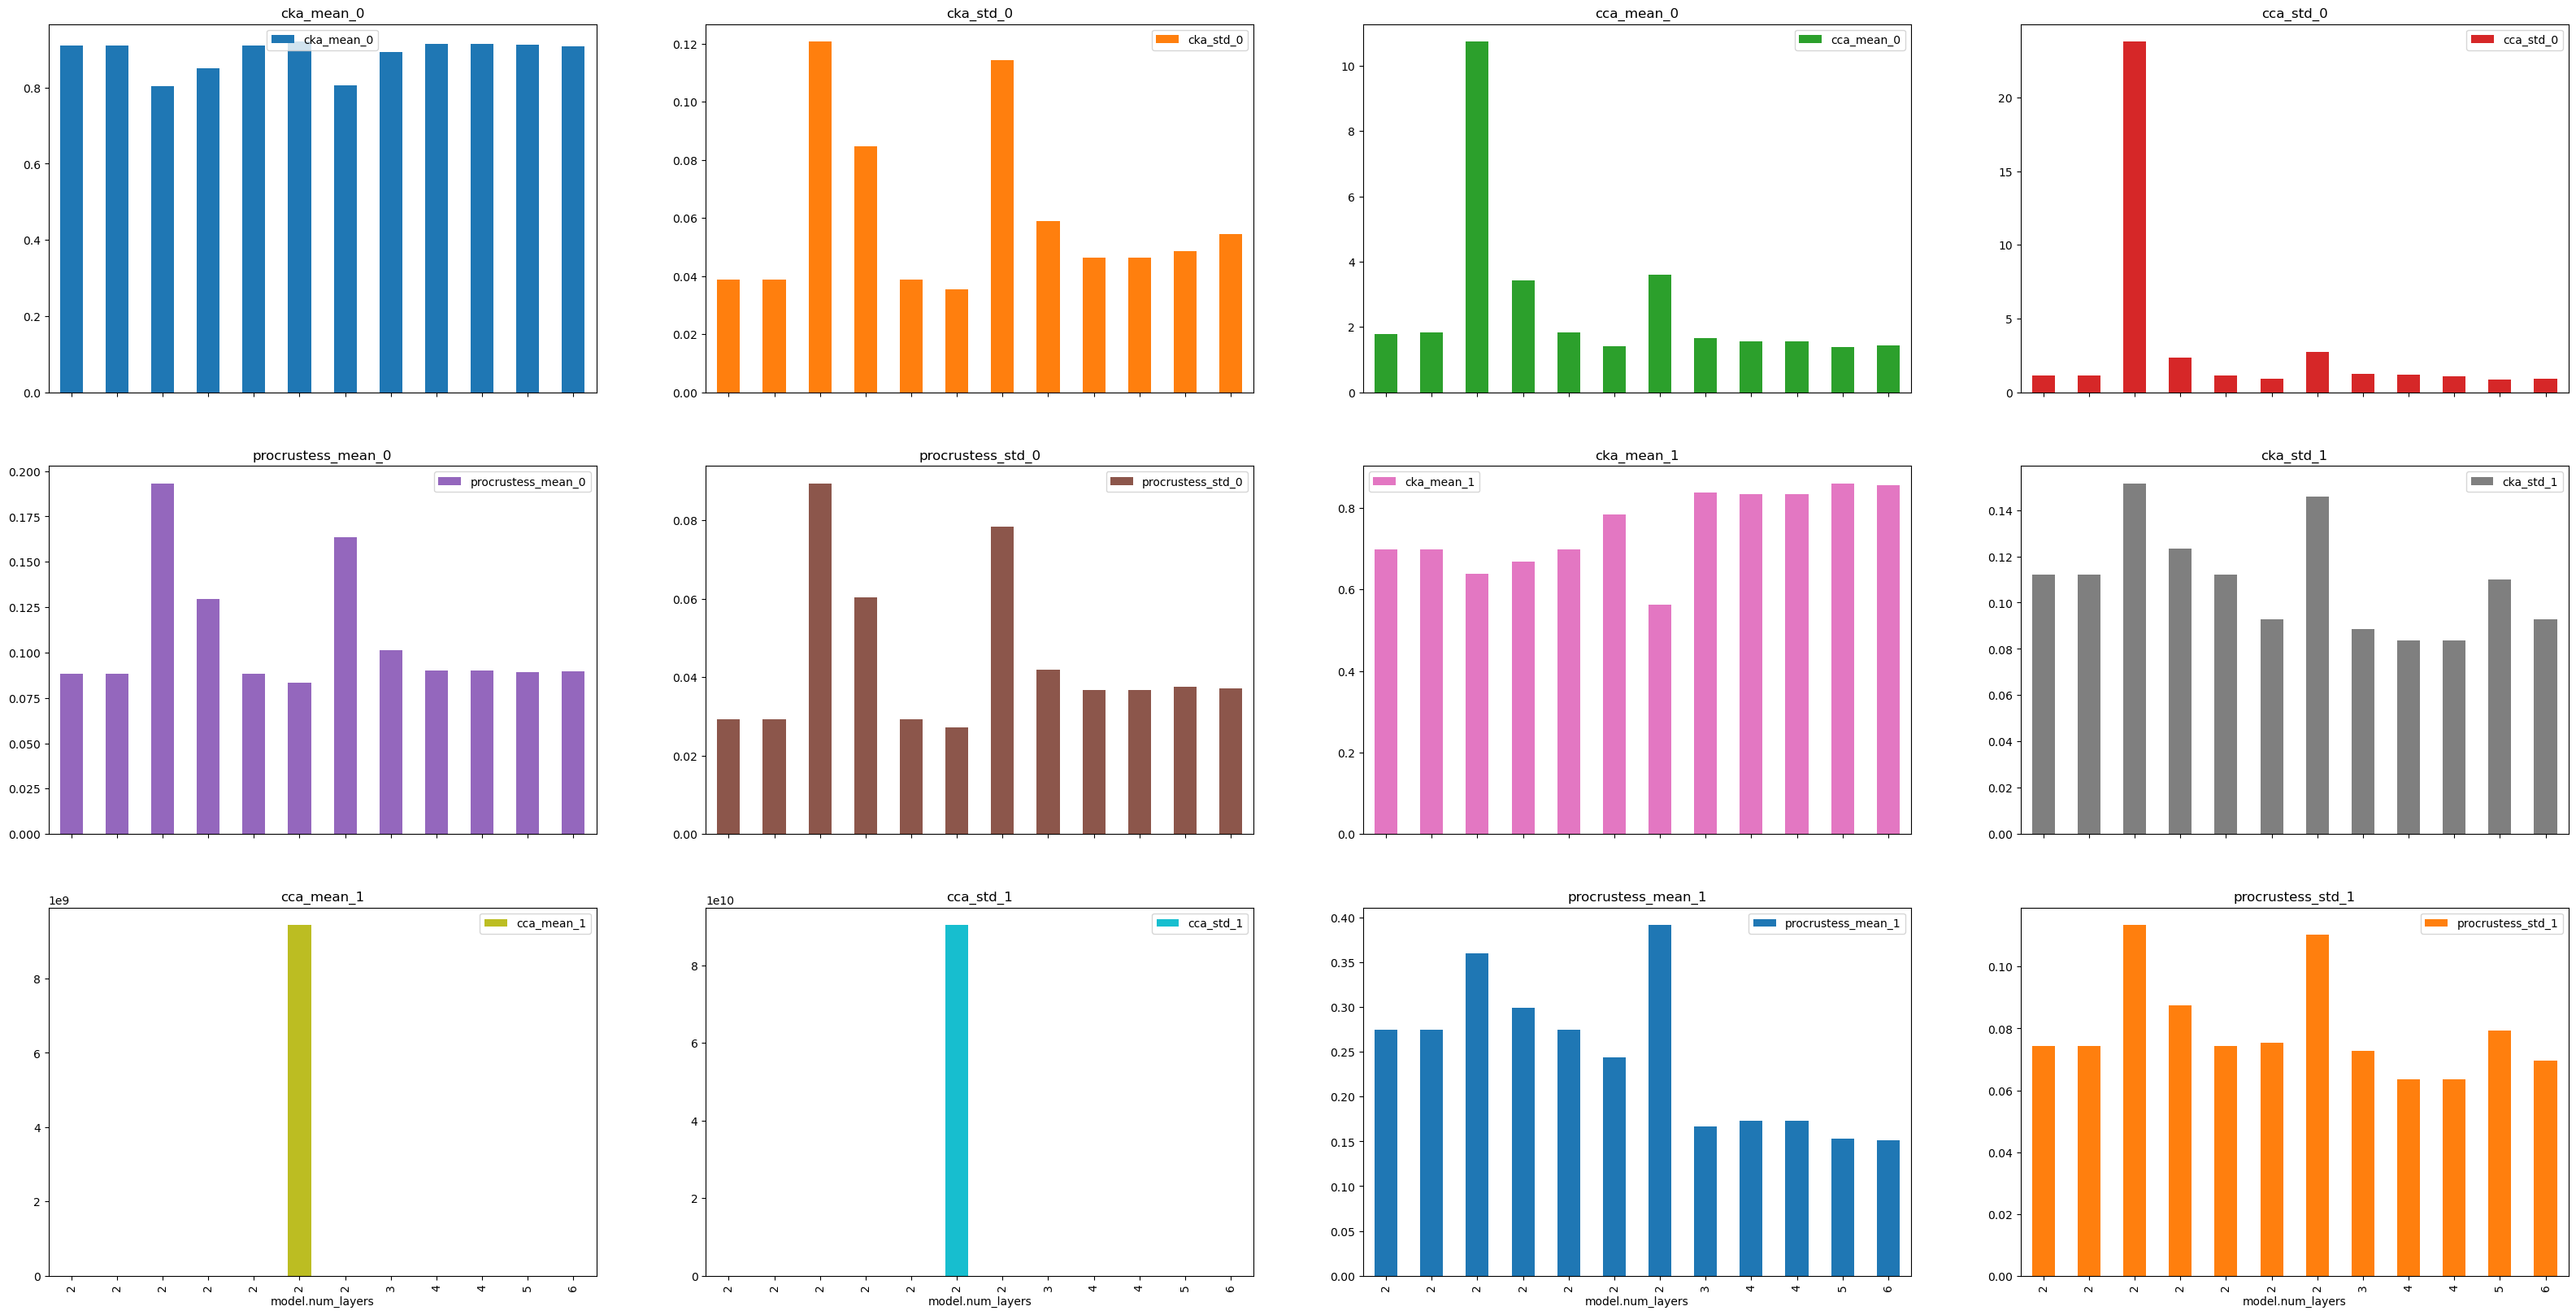

In [255]:
slice = df.loc[(df['model'] == 'gat') & (df['model.hidden_dim'] == 32) & (df['optim.weight_decay'] == 0)]
plot_df(slice, 'model.num_layers')

<Figure size 640x480 with 0 Axes>

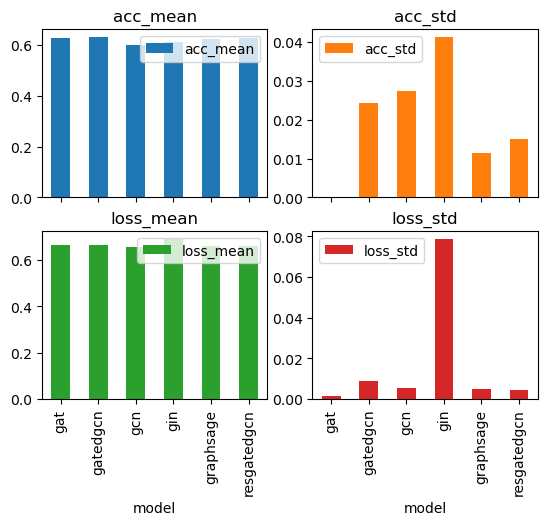

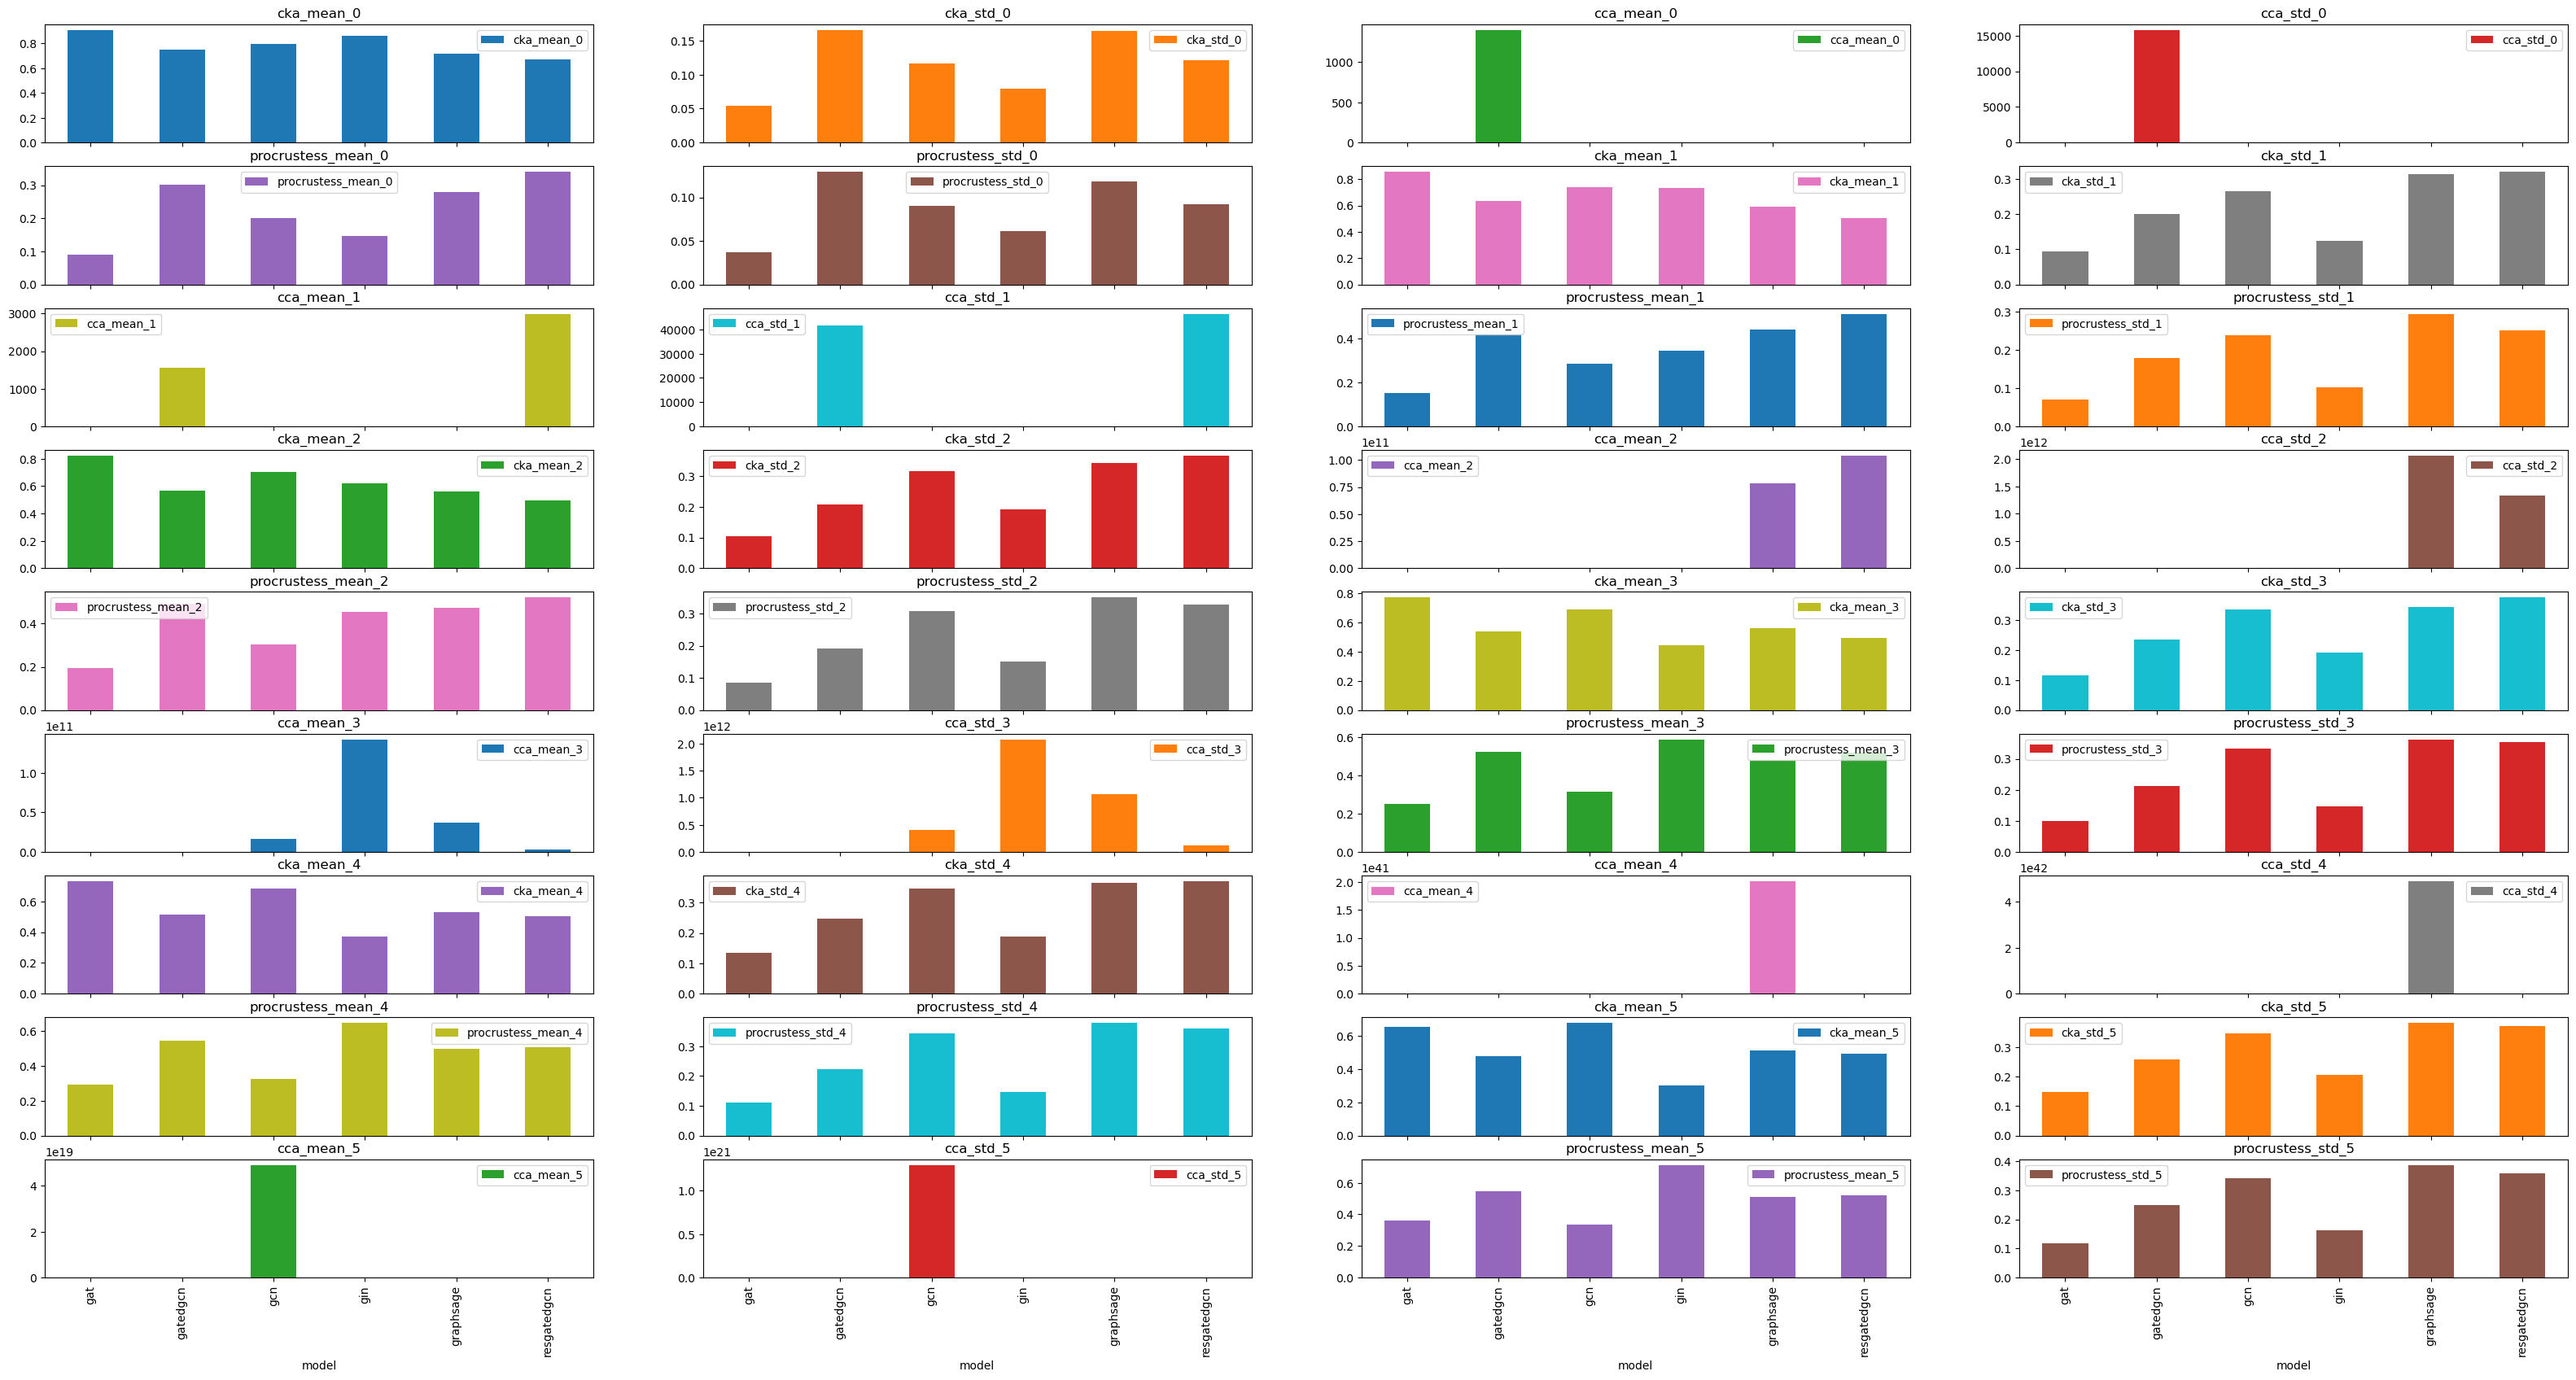

In [256]:
slice = df.loc[(df['model.num_layers'] == 6) & (df['model.hidden_dim'] == 32) & (df['optim.weight_decay'] == 0)]
plot_df(slice, 'model')

<Figure size 640x480 with 0 Axes>

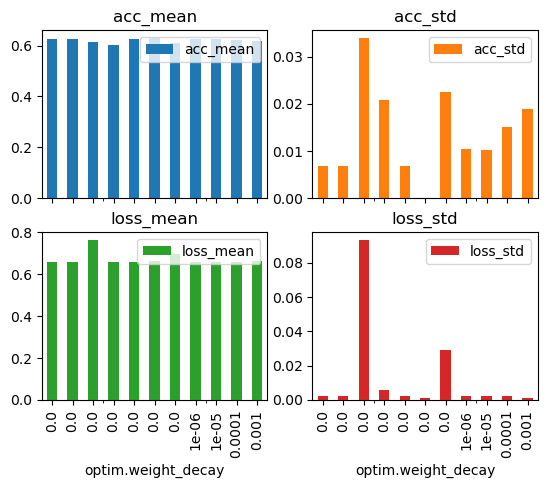

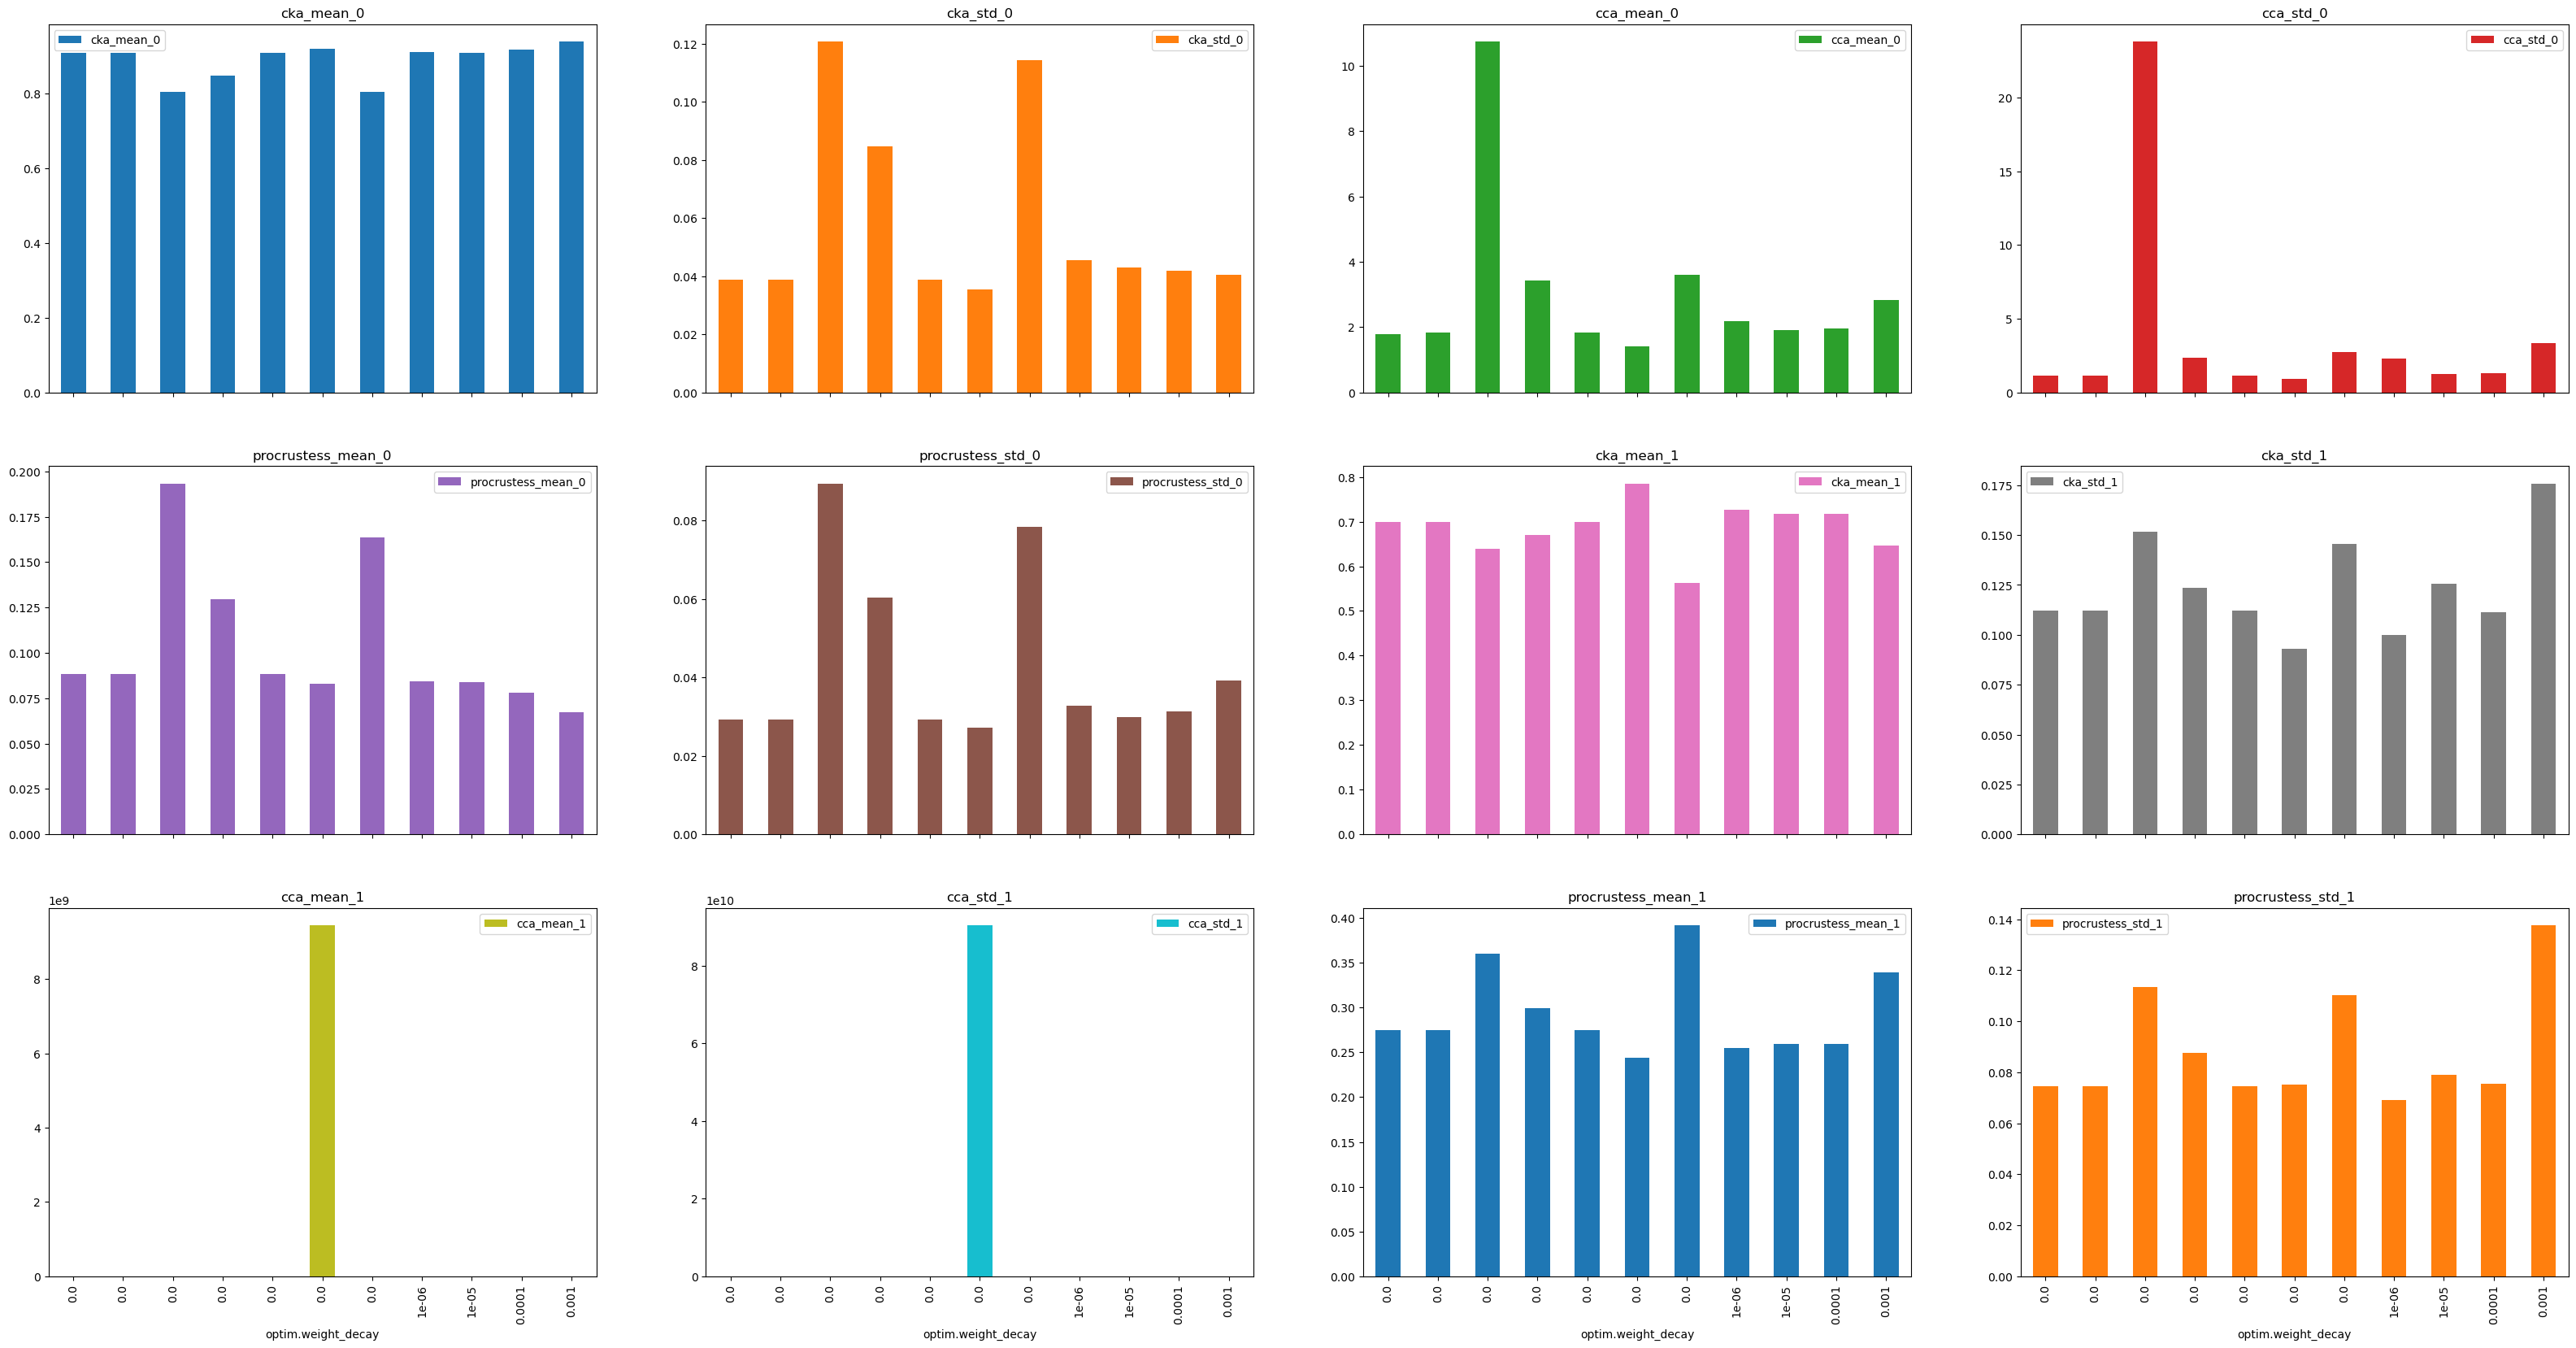

In [257]:
slice = df.loc[(df['model'] == 'gat') & (df['model.num_layers'] == 2) & (df['model.hidden_dim'] == 32)]
plot_df(slice, 'optim.weight_decay')

In [258]:
df = proteins_df

<Figure size 640x480 with 0 Axes>

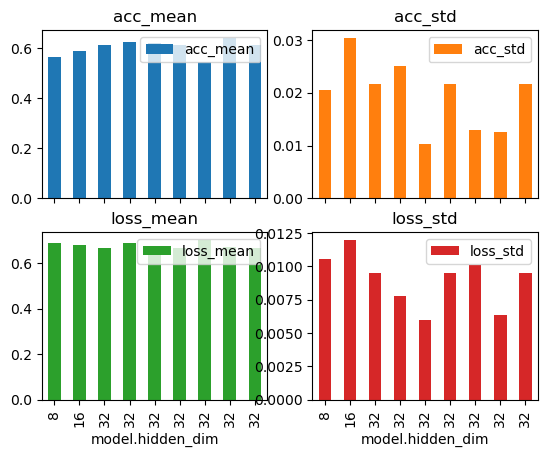

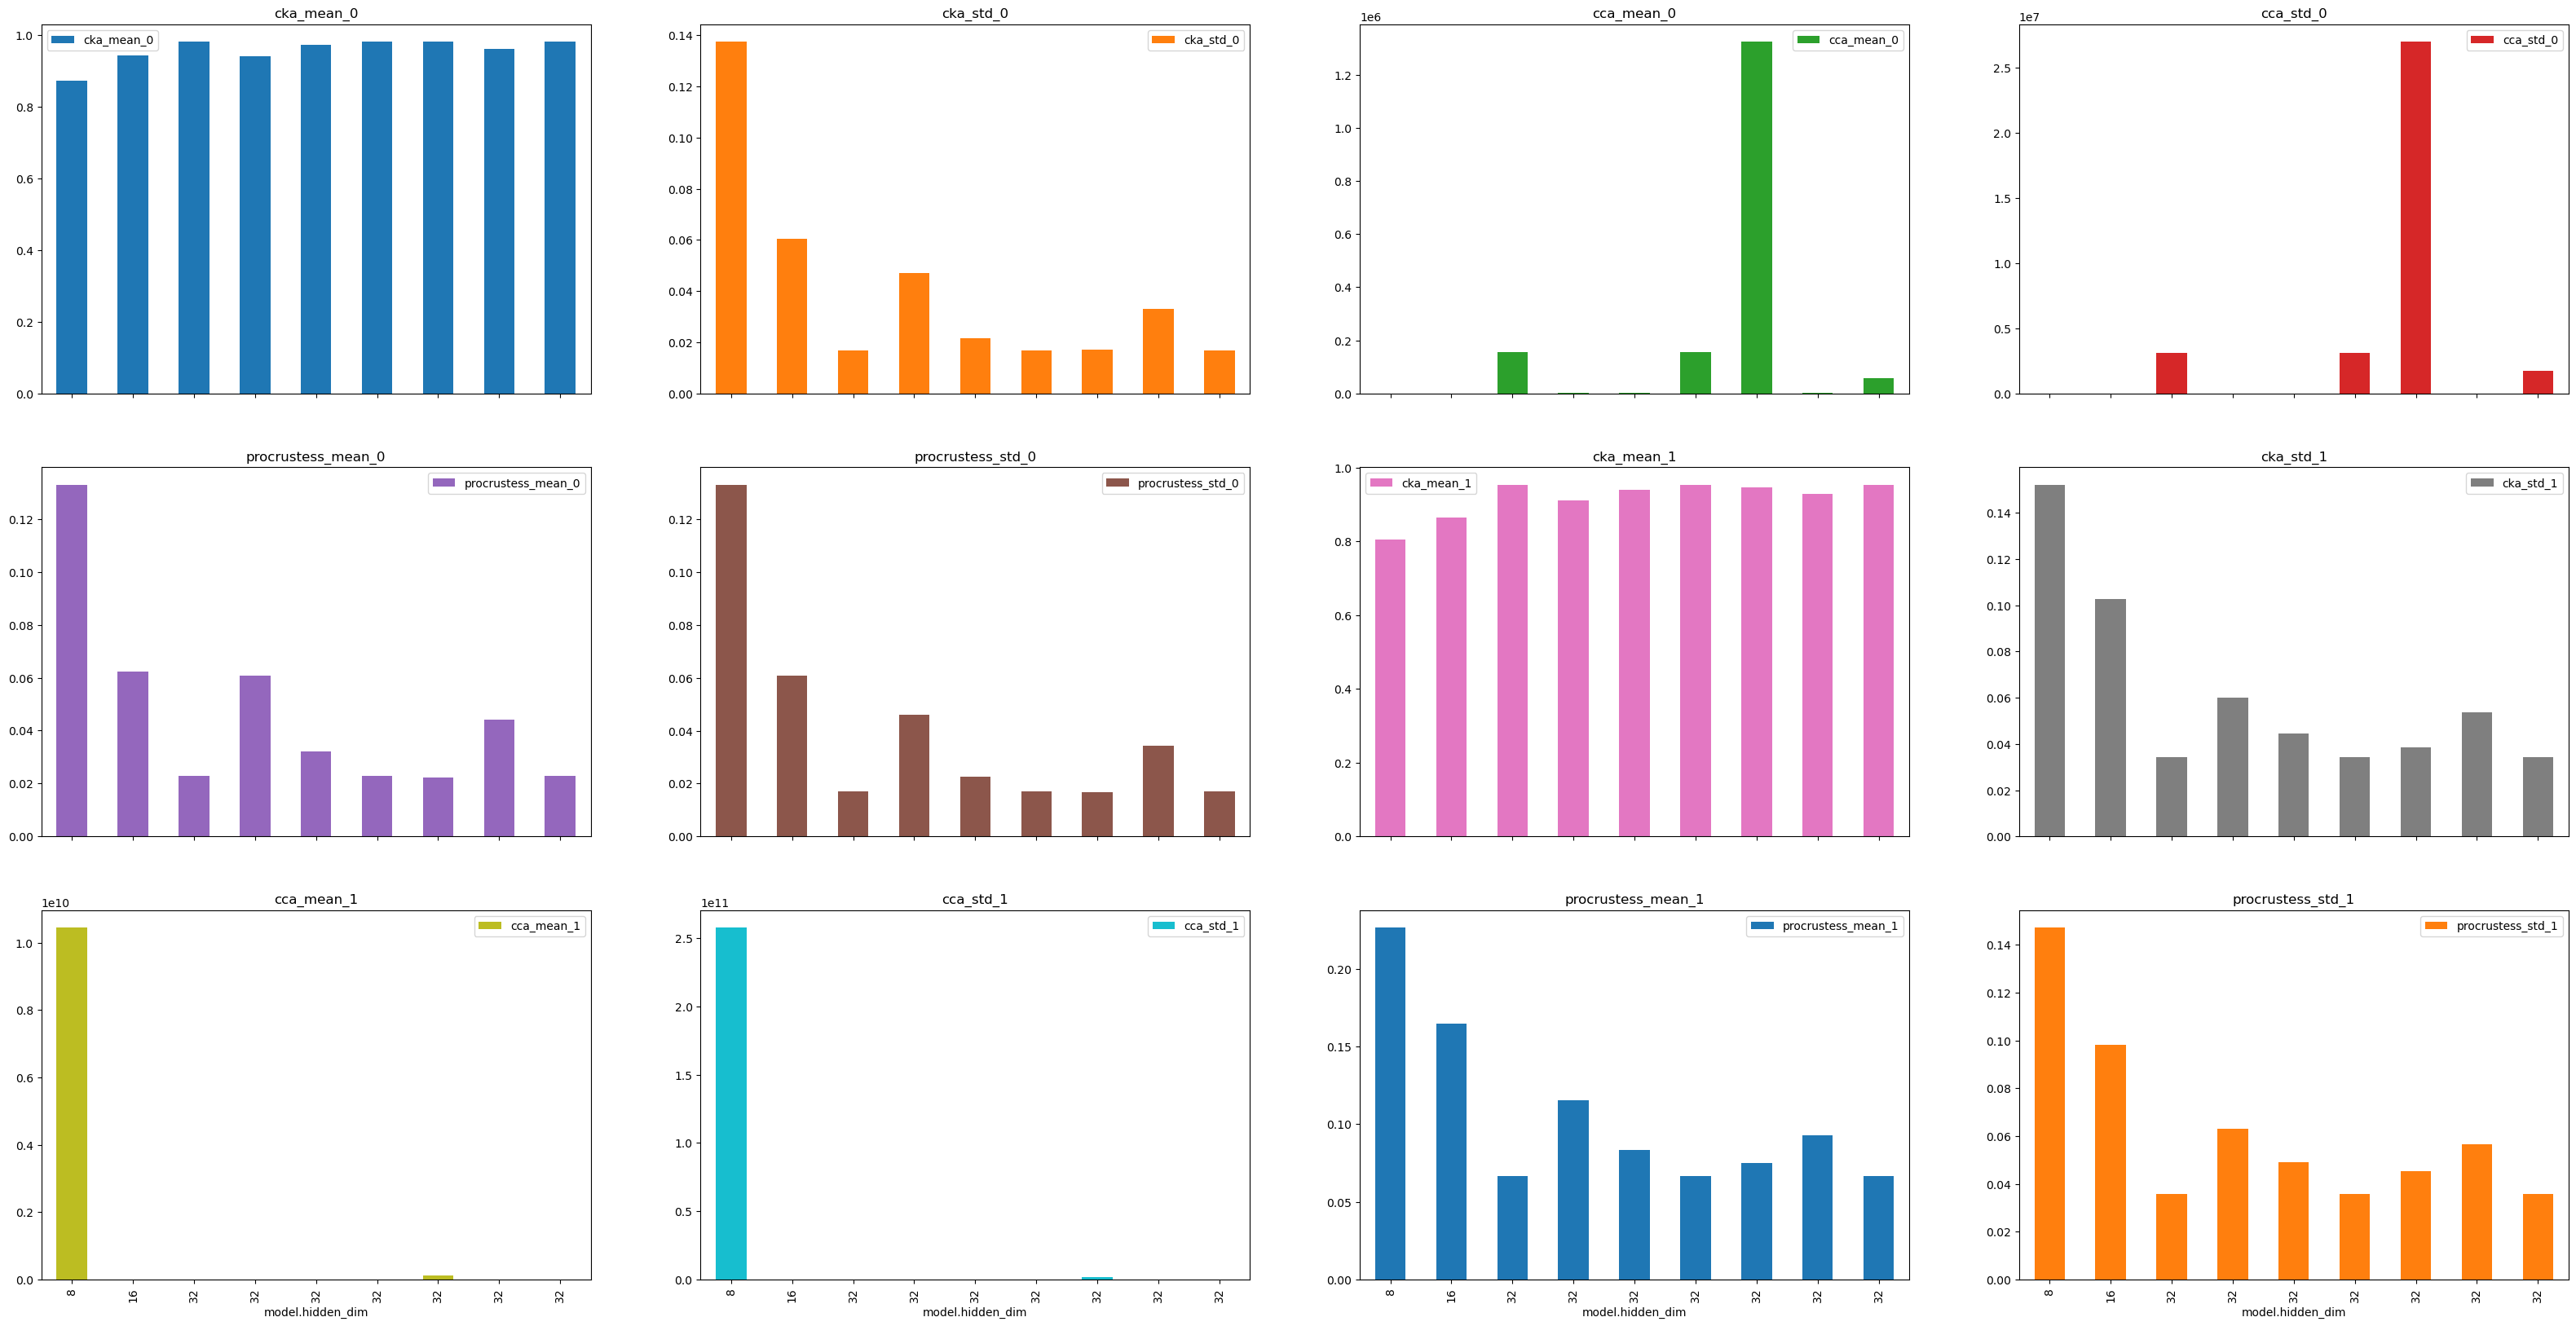

In [259]:
slice = df.loc[(df['model'] == 'gat') & (df['model.num_layers'] == 2) & (df['optim.weight_decay'] == 0)]
plot_df(slice, 'model.hidden_dim')

<Figure size 640x480 with 0 Axes>

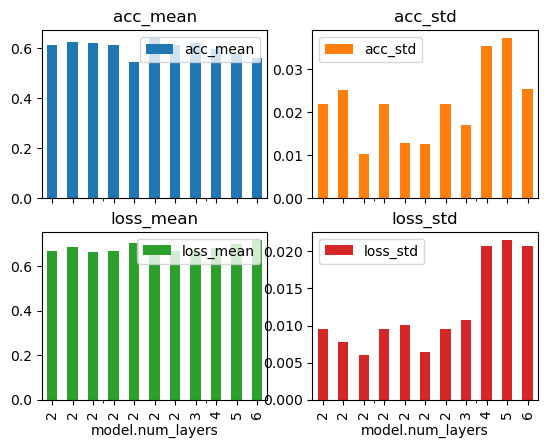

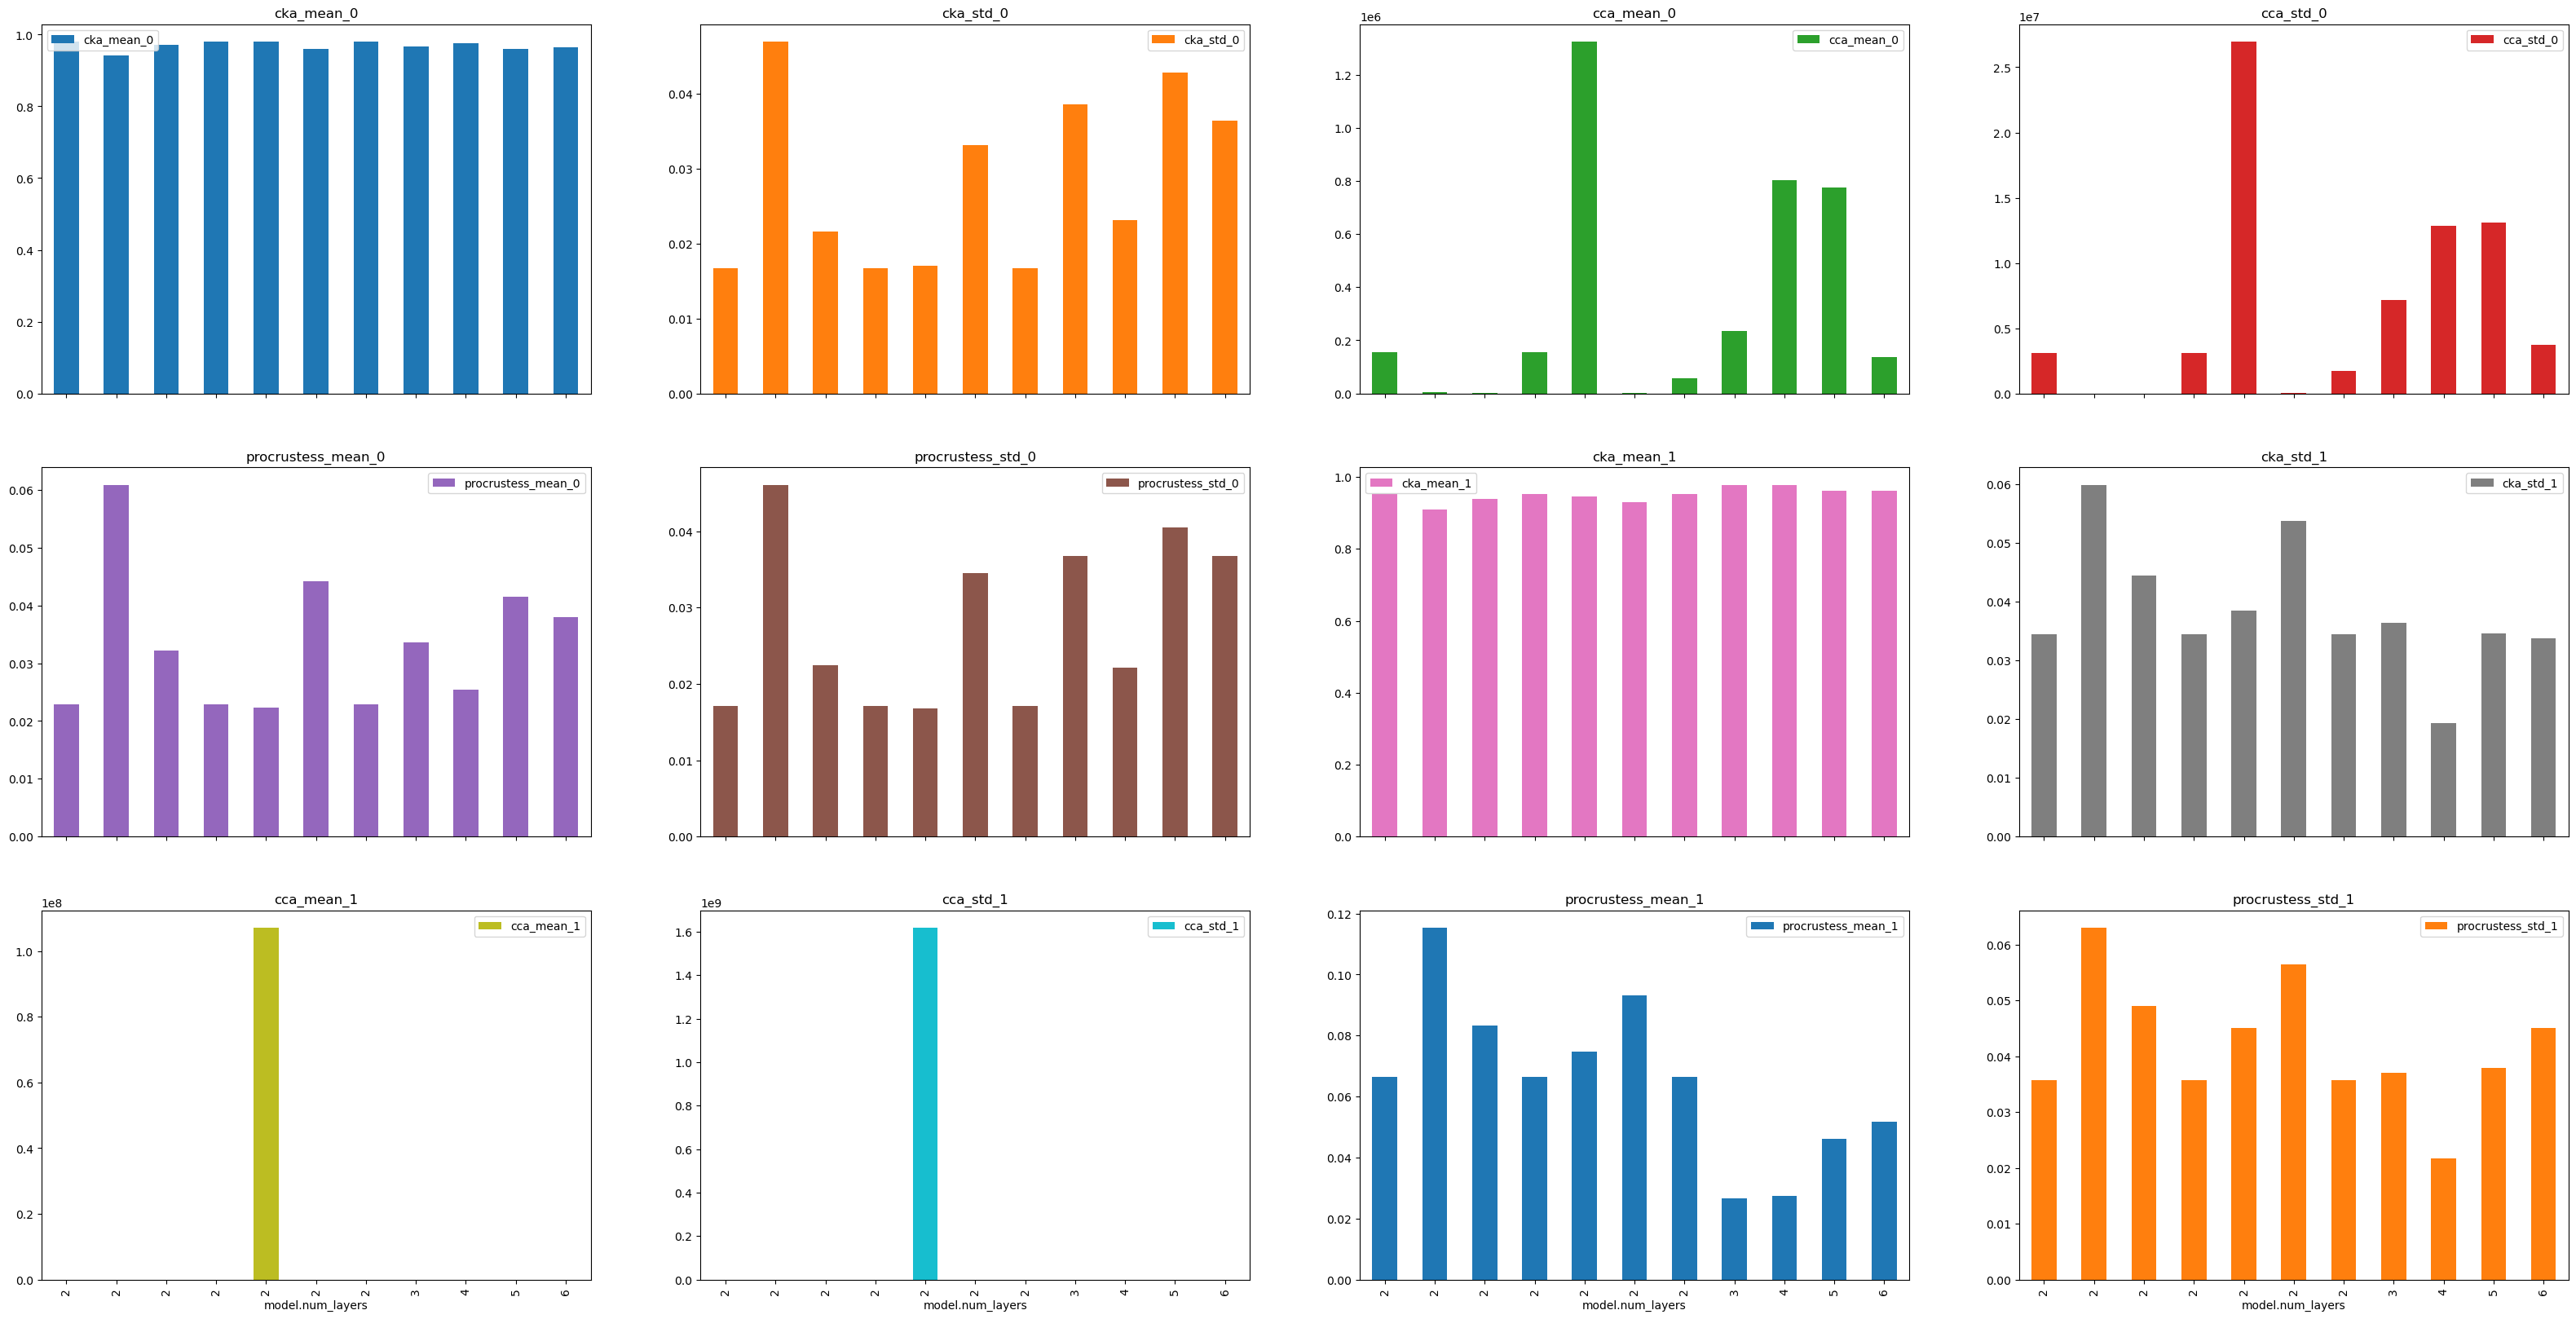

In [260]:
slice = df.loc[(df['model'] == 'gat') & (df['model.hidden_dim'] == 32) & (df['optim.weight_decay'] == 0)]
plot_df(slice, 'model.num_layers')

<Figure size 640x480 with 0 Axes>

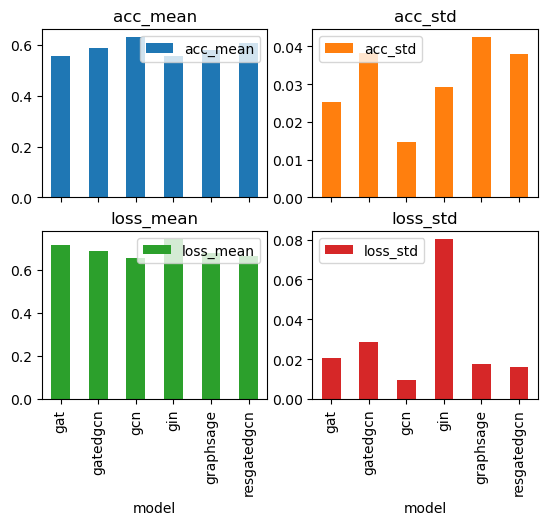

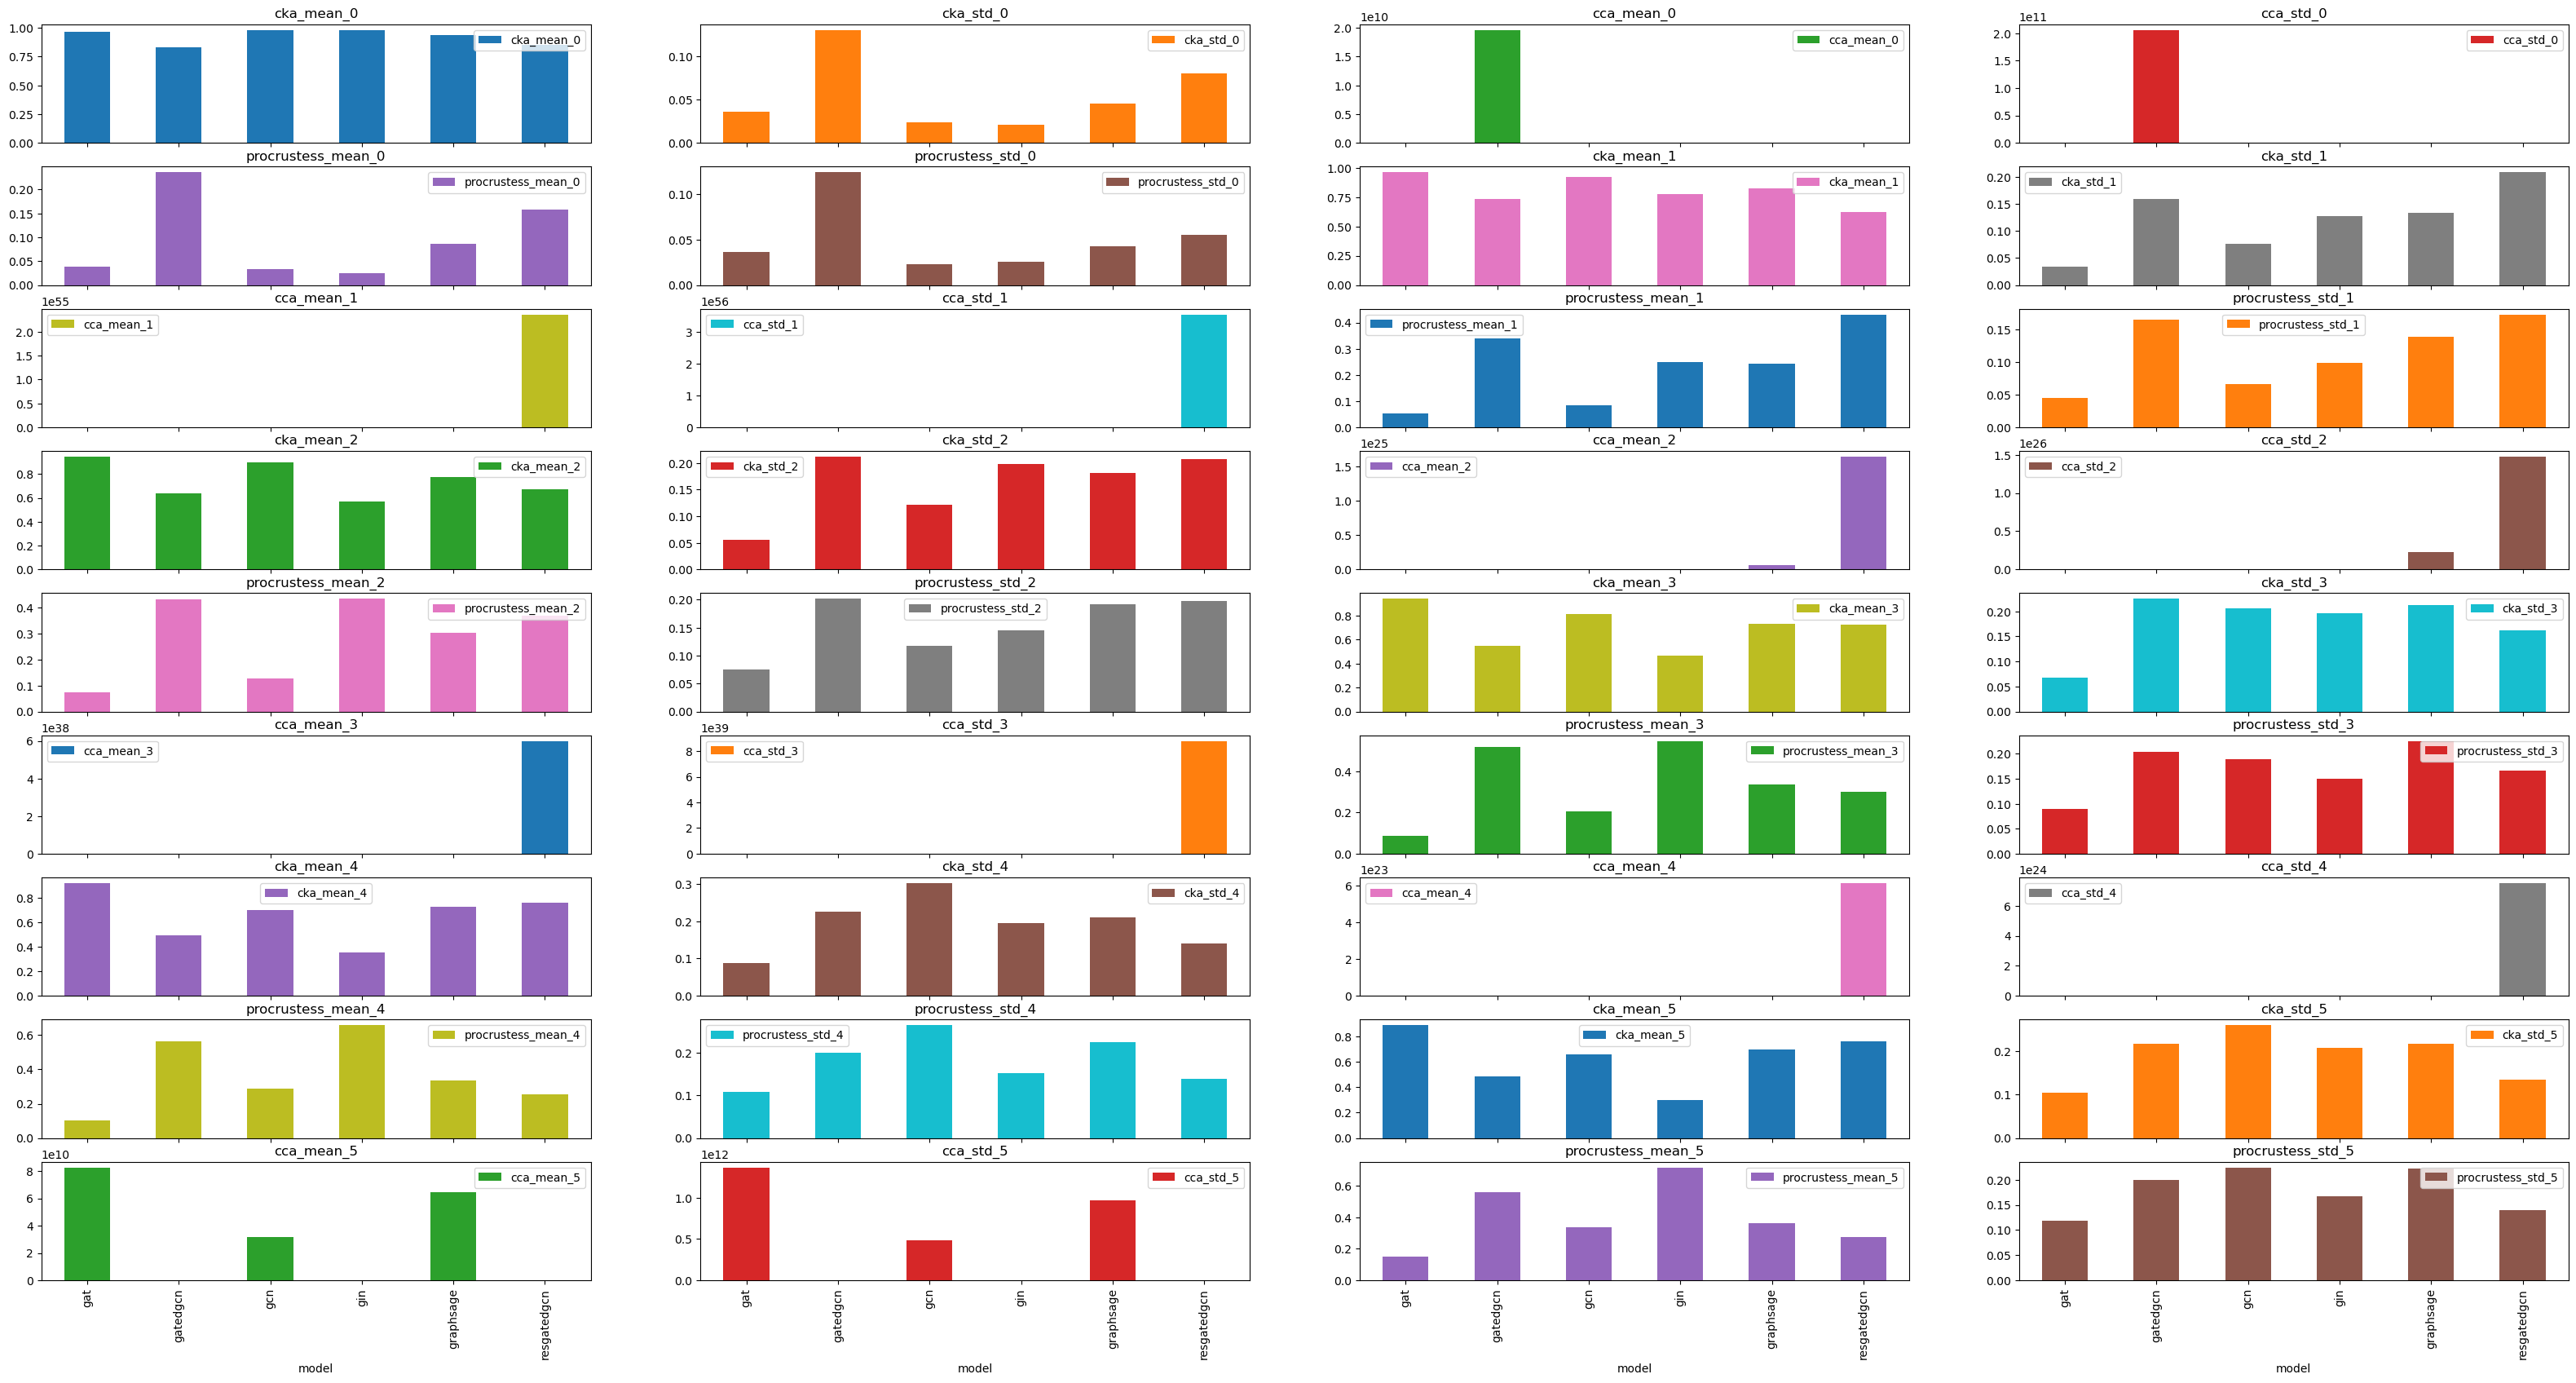

In [261]:
slice = df.loc[(df['model.num_layers'] == 6) & (df['model.hidden_dim'] == 32) & (df['optim.weight_decay'] == 0)]
plot_df(slice, 'model')

<Figure size 640x480 with 0 Axes>

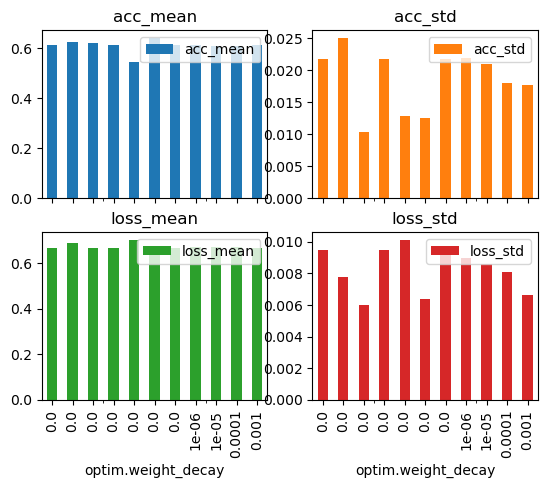

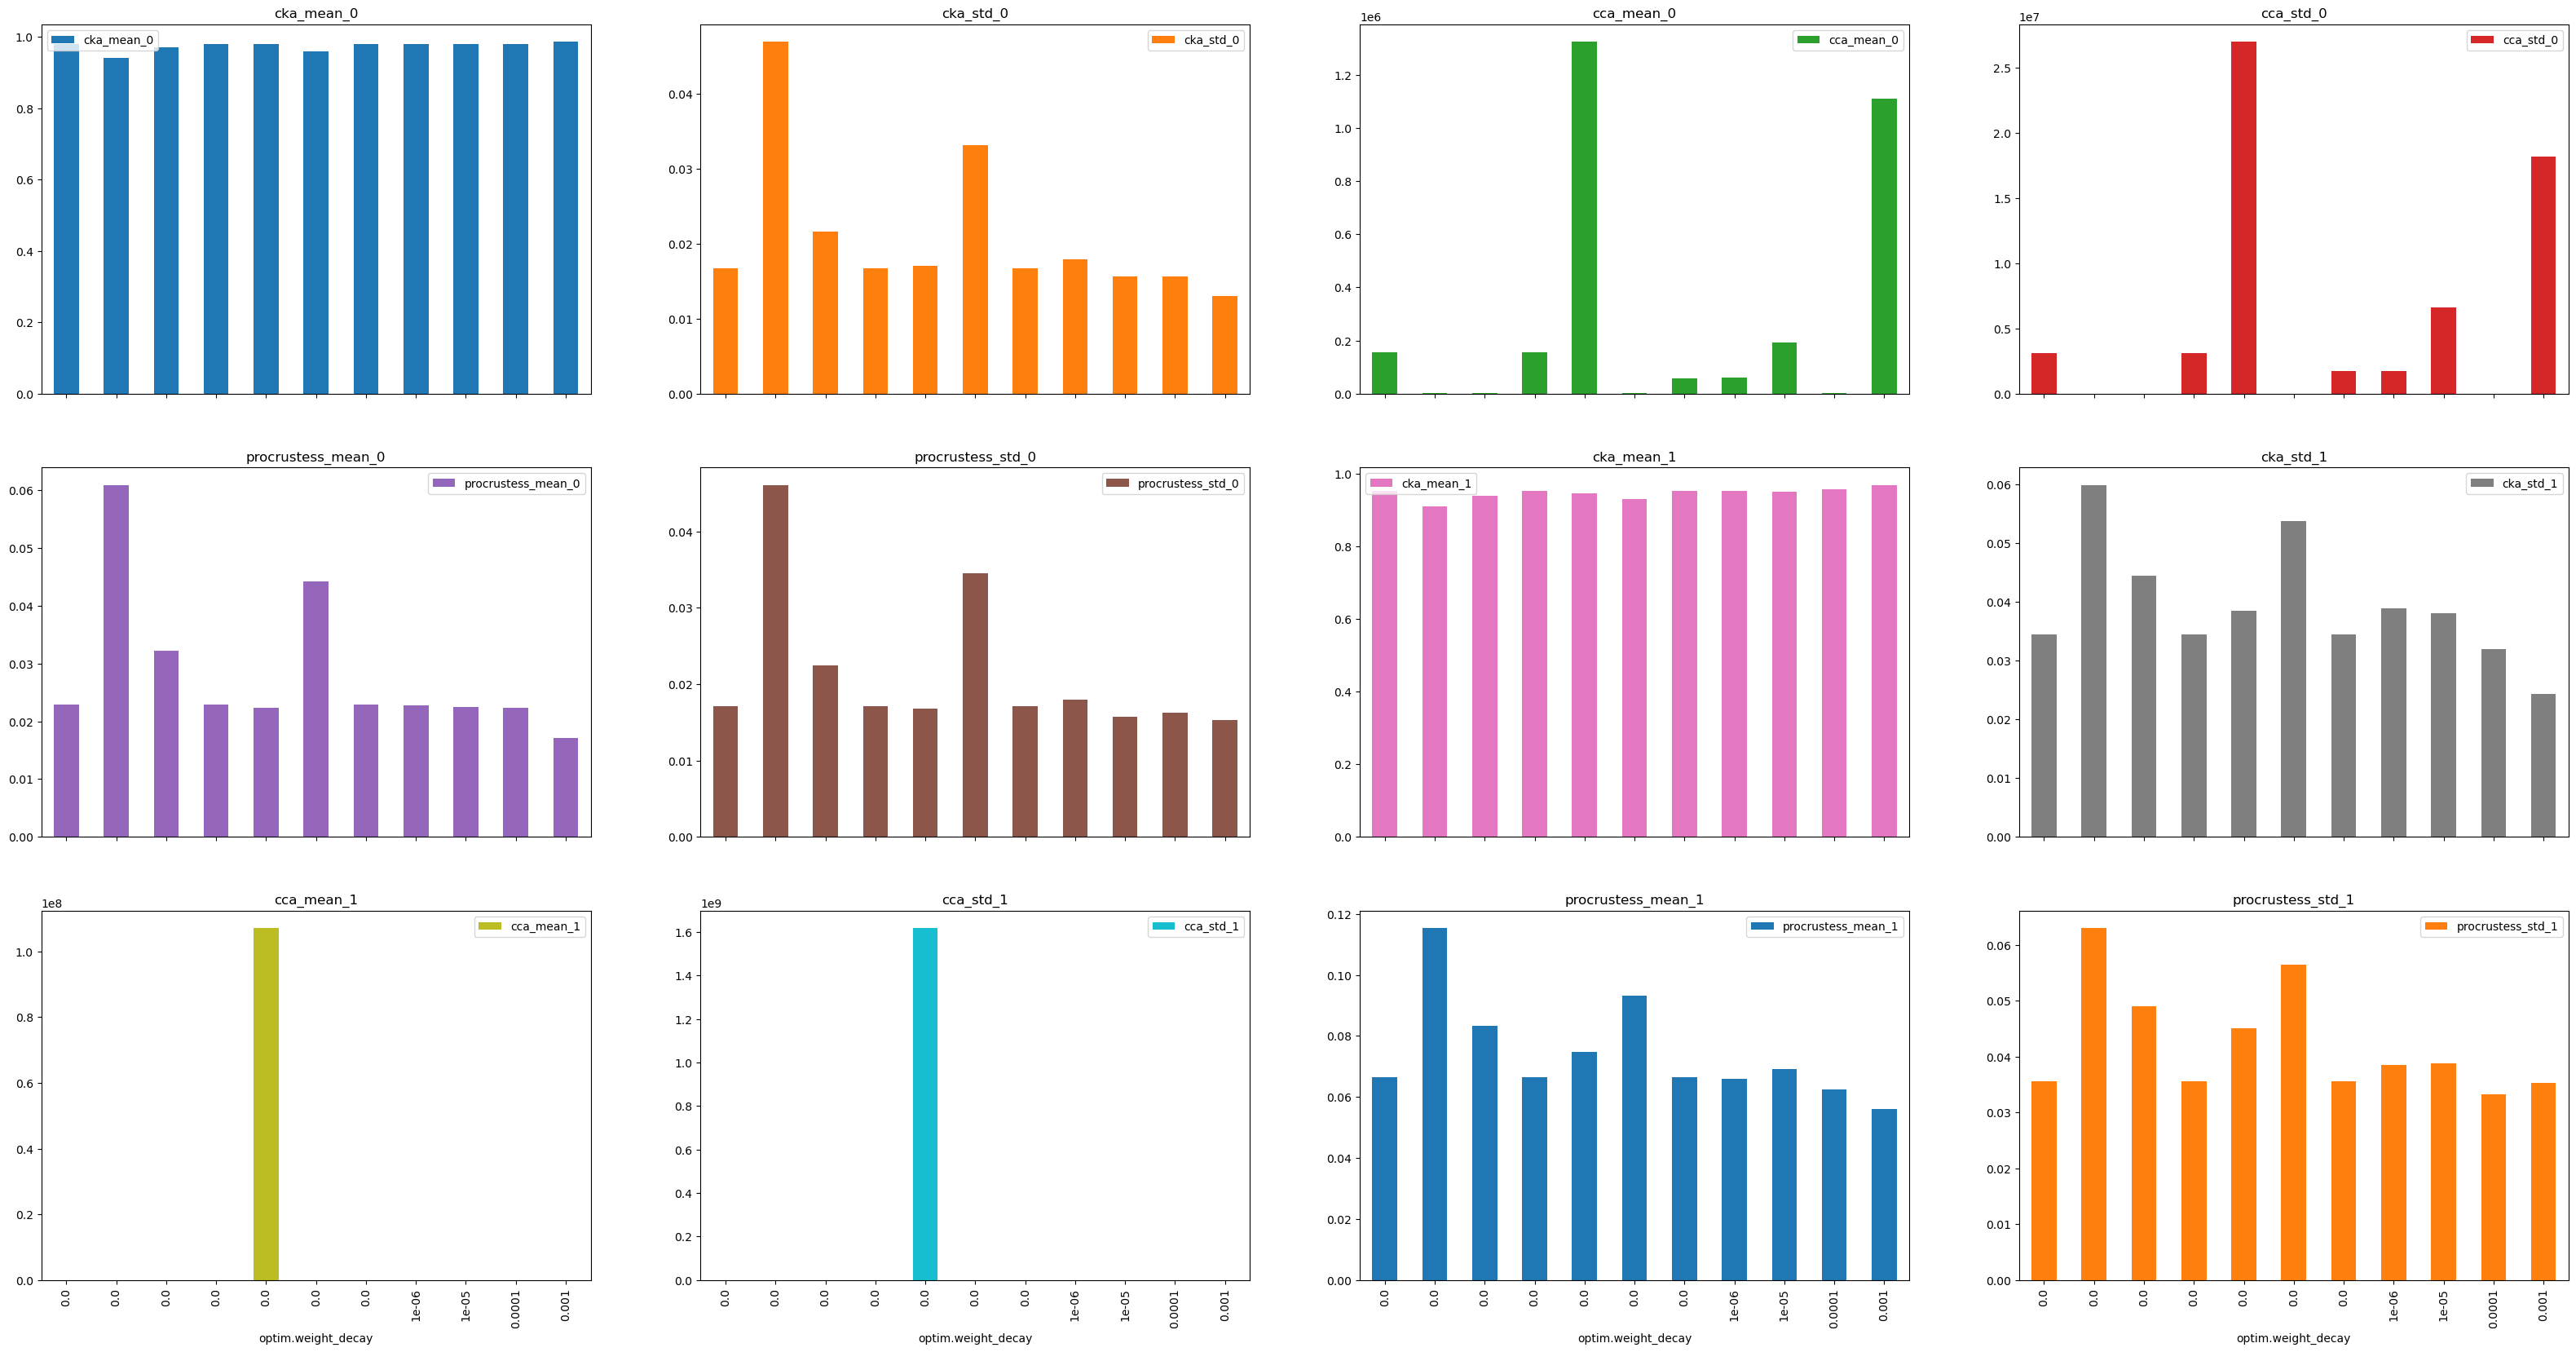

In [262]:
slice = df.loc[(df['model'] == 'gat') & (df['model.num_layers'] == 2) & (df['model.hidden_dim'] == 32)]
plot_df(slice, 'optim.weight_decay')

In [263]:
print(df['dataset'].unique())
print(df['model'].unique())
print(df['model.hidden_dim'].unique())
print(df['model.num_layers'].unique())
print(df['optim.name'].unique())
print(df['optim.learning_rate'].unique())
print(df['optim.weight_decay'].unique())
print(df['patience'].unique())

['proteins']
['gat' 'gatedgcn' 'graphsage' 'resgatedgcn' 'gcn' 'gin']
[32  8 16]
[2 3 4 5 6]
['Adam']
[0.01]
[0.e+00 1.e-06 1.e-05 1.e-04 1.e-03]
[40]


In [265]:
complete_df

,Unnamed: 0,optim.name,optim.learning_rate,optim.weight_decay,cka.use_masks,cka.mode,cka.save_to_disk,seed,datasplit_seed,keep_init_seed_constant,...,cka_std_5,procrustess_mean_5,procrustess_std_5,cca_mean_6,cca_std_6,cka_mean_6,cka_std_6,procrustess_mean_6,procrustess_std_6,model.dropout_p
0,0,Adam,0.01,0.0,test,diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Adam,0.01,0.0,test,diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Adam,0.01,0.0,test,diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Adam,0.01,0.0,test,diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Adam,0.01,0.0,test,diag,False,0,0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,454,Adam,0.01,0.0,test,diag,False,0,0,False,...,0.260384,0.339515,0.224568,NaN,NaN,NaN,NaN,NaN,NaN,NaN
455,455,Adam,0.01,0.0,test,diag,False,0,0,False,...,0.208589,0.718830,0.166967,0.287674,0.319326,0.251128,0.187465,0.763588,0.157443,NaN
456,456,Adam,0.01,0.0,test,diag,False,0,0,False,...,0.218286,0.364430,0.221648,NaN,NaN,NaN,NaN,NaN,NaN,NaN
457,457,Adam,0.01,0.0,test,diag,False,0,0,False,...,0.135220,0.273022,0.139011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
